# РТ5-61Б, Забурунов Л. В.

# Технологии Машинного Обучения

# Лабораторная Работа №5

## "Ансамблевые модели машинного обучения."

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostClassifier, CatBoostRegressor


Продолжим работу с датасетами под классификацию и регрессию. Посмотрим на различные с точки зрения "продвинутости" модели: бэггинг, случайный лес, CatBoost.

## Часть 1. Классификация

In [2]:
lab5_cl= pd.read_csv("ML_Datasets/pulsar_train_prepared.csv")
columns = lab5_cl.columns.to_list()

In [3]:
from sklearn.model_selection import train_test_split


RANDOM_STATE = 6
lab5_cl_x_train, lab5_cl_x_test, lab5_cl_y_train, lab5_cl_y_test = train_test_split(lab5_cl[columns[:-1]], 
                                                                                    lab5_cl[columns[-1]],
                                                                                    train_size = 0.85,
                                                                                    random_state = RANDOM_STATE)

### Бэггинг
Обучим модель, работающую по принципу чистого бэггинга, и посмотрим на показатели:

In [4]:
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix


def PrintClassificationMetrics(y_test, y_predicted):
    print("-Погрешность (accuracy, balanced) = {0};\
          \n-Меткость (precision, класс 1) = {1};\
          \n-Полнота (recall, класс 1) = {2};\
          \n-F1 (класс 1) = {3};\
          \n-ROC AUC = {4}.".format(balanced_accuracy_score(y_test, y_predicted),
                                   precision_score(y_test, y_predicted, average = "binary"),
                                   recall_score(y_test, y_predicted, average = "binary"),
                                   f1_score(y_test, y_predicted, average = "binary"),
                                   roc_auc_score(y_test, y_predicted)))
    
def FitPredictCl(model, x_train, x_test, y_train, y_test):
    solver = model
    solver.fit(x_train, y_train)
    prediction = solver.predict(x_test)
    PrintClassificationMetrics(y_test, prediction)
    plot_confusion_matrix(model, x_test, y_test)

In [5]:
bagging_cl = BaggingClassifier(random_state = RANDOM_STATE)

-Погрешность (accuracy, balanced) = 0.933331235951914;          
-Меткость (precision, класс 1) = 0.9182389937106918;          
-Полнота (recall, класс 1) = 0.874251497005988;          
-F1 (класс 1) = 0.8957055214723927;          
-ROC AUC = 0.933331235951914.


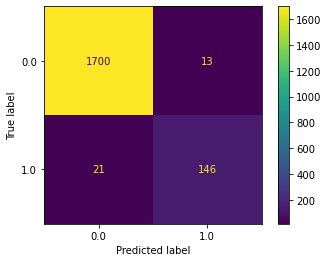

In [6]:
FitPredictCl(bagging_cl, lab5_cl_x_train, lab5_cl_x_test, lab5_cl_y_train, lab5_cl_y_test)

Видим хорошее качество для базового решения: если посмотреть на результаты 4-ой лабораторной, то видим, что метрики напоминают улучшенное дерево решений (чем обученная модель и является).

Теперь воспользуемся решётчатым поиском для поиска наилучшей сильной модели с точки зрения числа слабых.

In [7]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit


estimators_range = [i for i in range(1, 25)]
cv_scoring_strategies = {"Balanced Accuracy Score" : "balanced_accuracy", 
                         "Recall Score (class 1)" : "recall",
                         "Recall Score (weighted avg)" : "recall_weighted",
                         "Precision Score (class 1)" : "precision",
                         "Precision Score (weighted avg)" : "precision_weighted",
                         "ROC AUC Score" : "roc_auc"}

bagging_cl_grid = GridSearchCV(estimator = BaggingClassifier(random_state = RANDOM_STATE),
                              param_grid = [{"n_estimators" : estimators_range}],
                              cv = StratifiedShuffleSplit(random_state = RANDOM_STATE),
                              n_jobs = 8,
                              scoring = cv_scoring_strategies,
                              refit = False,
                              return_train_score = True)

bagging_cl_grid.fit(lab5_cl[columns[:-1]], lab5_cl[columns[-1]])

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=6, test_size=None,
            train_size=None),
             estimator=BaggingClassifier(random_state=6), n_jobs=8,
             param_grid=[{'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13, 14, 15, 16, 17, 18, 19, 20,
                                           21, 22, 23, 24]}],
             refit=False, return_train_score=True,
             scoring={'Balanced Accuracy Score': 'balanced_accuracy',
                      'Precision Score (class 1)': 'precision',
                      'Precision Score (weighted avg)': 'precision_weighted',
                      'ROC AUC Score': 'roc_auc',
                      'Recall Score (class 1)': 'recall',
                      'Recall Score (weighted avg)': 'recall_weighted'})

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def PlotGridSearchResults(strategies, grid, param_range, xmin, xmax, ymin, ymax):
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))

    for strategy in strategies:
        ax.plot(param_range, grid.cv_results_["mean_test_{}".format(strategy)], label = strategy + " (test score)")
        #ax.plot(param_range, grid.cv_results_["mean_train_{}".format(strategy)], label = strategy + " (train score)")

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xticks(param_range)
    plt.legend(loc="best")

    plt.show()


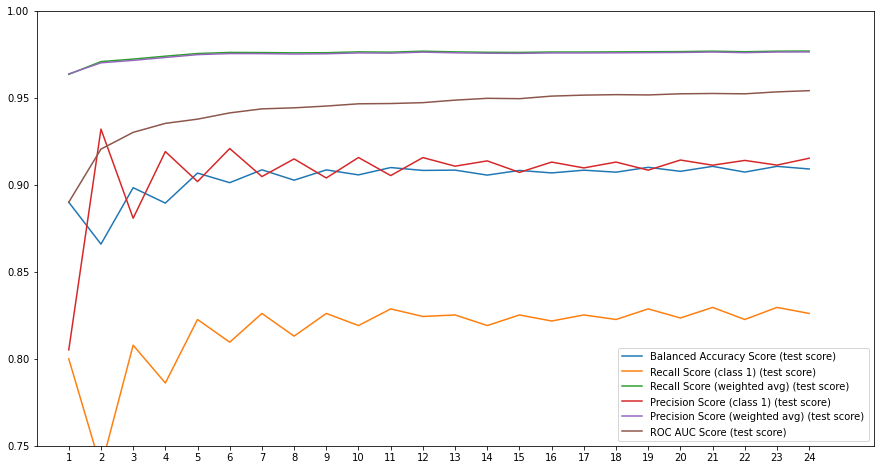

In [9]:
PlotGridSearchResults(cv_scoring_strategies, bagging_cl_grid, estimators_range, 0, 26, 0.75, 1)

Результат можно трактовать следующим образом: больше 4 слабых моделей в ансамбле не требуется. Видим, что борьба с переобучение эффективна уже даже для ансамбля из двух деревьев.

Видим другую интересную особенность: график качества по некоторым метрикам напоминает затухающие колебания. С чем это связано - ответить сложно, поскольку интуитивное предположение было бы таким: при чётном количестве слабых моделей взаимная ошибка попарно компенсируется и в итоге складывается лучший результат, нежели для нечётного количества. Однако, работает это не во всех случаях.

Обучать другие модели не будем, поскольку видим, что "из коробки" показатели ничем не уступают.
### Случайный лес

In [10]:
rf_cl = RandomForestClassifier(random_state = RANDOM_STATE)

-Погрешность (accuracy, balanced) = 0.9327474647902094;          
-Меткость (precision, класс 1) = 0.906832298136646;          
-Полнота (recall, класс 1) = 0.874251497005988;          
-F1 (класс 1) = 0.8902439024390244;          
-ROC AUC = 0.9327474647902094.


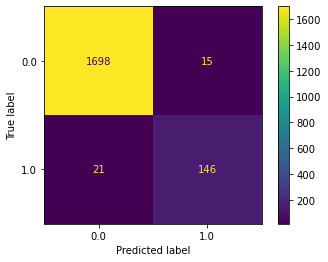

In [11]:
FitPredictCl(rf_cl, lab5_cl_x_train, lab5_cl_x_test, lab5_cl_y_train, lab5_cl_y_test)

Случайный лес на сотне деревьев показывает такие же результаты, как и бэггинг!

Попробуем подобрать гиперпараметры

In [12]:
estimators_range = [i for i in range(1, 102, 4)]
cv_scoring_strategies = {"Balanced Accuracy Score" : "balanced_accuracy", 
                         "Recall Score (class 1)" : "recall",
                         "Recall Score (weighted avg)" : "recall_weighted",
                         "Precision Score (class 1)" : "precision",
                         "Precision Score (weighted avg)" : "precision_weighted",
                         "ROC AUC Score" : "roc_auc"}

rf_cl_grid = GridSearchCV(estimator = RandomForestClassifier(random_state = RANDOM_STATE),
                              param_grid = [{"n_estimators" : estimators_range}],
                              cv = StratifiedShuffleSplit(random_state = RANDOM_STATE),
                              n_jobs = 8,
                              scoring = cv_scoring_strategies,
                              refit = False,
                              return_train_score = True)

rf_cl_grid.fit(lab5_cl[columns[:-1]], lab5_cl[columns[-1]])

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=6, test_size=None,
            train_size=None),
             estimator=RandomForestClassifier(random_state=6), n_jobs=8,
             param_grid=[{'n_estimators': [1, 5, 9, 13, 17, 21, 25, 29, 33, 37,
                                           41, 45, 49, 53, 57, 61, 65, 69, 73,
                                           77, 81, 85, 89, 93, 97, 101]}],
             refit=False, return_train_score=True,
             scoring={'Balanced Accuracy Score': 'balanced_accuracy',
                      'Precision Score (class 1)': 'precision',
                      'Precision Score (weighted avg)': 'precision_weighted',
                      'ROC AUC Score': 'roc_auc',
                      'Recall Score (class 1)': 'recall',
                      'Recall Score (weighted avg)': 'recall_weighted'})

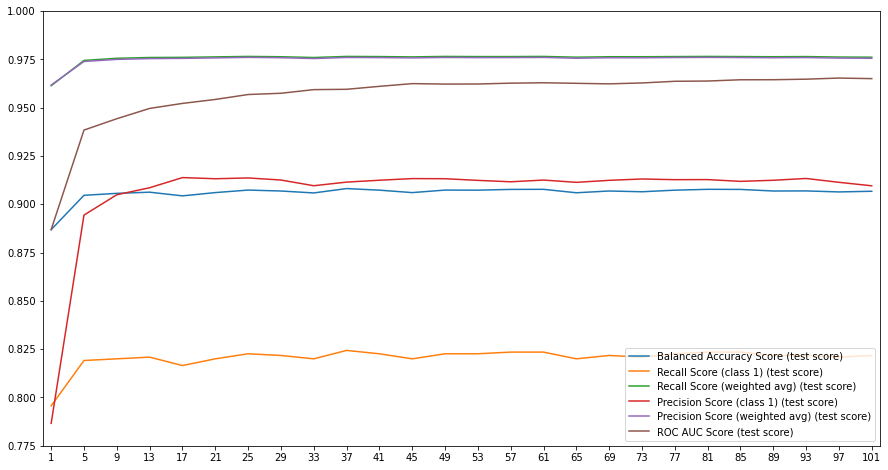

In [13]:
PlotGridSearchResults(cv_scoring_strategies, rf_cl_grid, estimators_range, 0, 102, 0.775, 1)

Тоже никаких сюрпризов: однозначные улучшения качества имеются только в диапазоне до 10 слабых моделей, поэтому обучать другие модели не будем.
### CatBoost

In [14]:
cb_cl = CatBoostClassifier(random_seed = RANDOM_STATE)
cb_cl.fit(lab5_cl_x_train, lab5_cl_y_train)
cb_cl_prediction = cb_cl.predict(lab5_cl_x_test)

Learning rate set to 0.028286
0:	learn: 0.6327847	total: 177ms	remaining: 2m 56s
1:	learn: 0.5796967	total: 189ms	remaining: 1m 34s
2:	learn: 0.5357753	total: 202ms	remaining: 1m 6s
3:	learn: 0.4947306	total: 210ms	remaining: 52.3s
4:	learn: 0.4583833	total: 218ms	remaining: 43.3s
5:	learn: 0.4209068	total: 225ms	remaining: 37.3s
6:	learn: 0.3905749	total: 233ms	remaining: 33.1s
7:	learn: 0.3611025	total: 241ms	remaining: 29.9s
8:	learn: 0.3349299	total: 250ms	remaining: 27.5s
9:	learn: 0.3115018	total: 257ms	remaining: 25.5s
10:	learn: 0.2896160	total: 265ms	remaining: 23.8s
11:	learn: 0.2706523	total: 273ms	remaining: 22.5s
12:	learn: 0.2545466	total: 281ms	remaining: 21.4s
13:	learn: 0.2393243	total: 289ms	remaining: 20.4s
14:	learn: 0.2252675	total: 297ms	remaining: 19.5s
15:	learn: 0.2110355	total: 306ms	remaining: 18.8s
16:	learn: 0.2008552	total: 313ms	remaining: 18.1s
17:	learn: 0.1904675	total: 321ms	remaining: 17.5s
18:	learn: 0.1809938	total: 329ms	remaining: 17s
19:	learn: 

160:	learn: 0.0623173	total: 1.47s	remaining: 7.64s
161:	learn: 0.0622358	total: 1.47s	remaining: 7.63s
162:	learn: 0.0621527	total: 1.48s	remaining: 7.61s
163:	learn: 0.0620889	total: 1.49s	remaining: 7.6s
164:	learn: 0.0620376	total: 1.5s	remaining: 7.58s
165:	learn: 0.0619414	total: 1.51s	remaining: 7.57s
166:	learn: 0.0618766	total: 1.51s	remaining: 7.55s
167:	learn: 0.0618131	total: 1.52s	remaining: 7.54s
168:	learn: 0.0617453	total: 1.53s	remaining: 7.52s
169:	learn: 0.0617010	total: 1.54s	remaining: 7.51s
170:	learn: 0.0616719	total: 1.54s	remaining: 7.49s
171:	learn: 0.0616150	total: 1.55s	remaining: 7.48s
172:	learn: 0.0615243	total: 1.56s	remaining: 7.46s
173:	learn: 0.0614273	total: 1.57s	remaining: 7.45s
174:	learn: 0.0613197	total: 1.58s	remaining: 7.44s
175:	learn: 0.0611956	total: 1.58s	remaining: 7.42s
176:	learn: 0.0611123	total: 1.59s	remaining: 7.41s
177:	learn: 0.0609970	total: 1.6s	remaining: 7.4s
178:	learn: 0.0609533	total: 1.61s	remaining: 7.39s
179:	learn: 0.06

323:	learn: 0.0522404	total: 2.73s	remaining: 5.71s
324:	learn: 0.0521913	total: 2.74s	remaining: 5.69s
325:	learn: 0.0521498	total: 2.75s	remaining: 5.68s
326:	learn: 0.0520937	total: 2.76s	remaining: 5.67s
327:	learn: 0.0520380	total: 2.76s	remaining: 5.66s
328:	learn: 0.0520177	total: 2.77s	remaining: 5.65s
329:	learn: 0.0519333	total: 2.78s	remaining: 5.64s
330:	learn: 0.0519006	total: 2.79s	remaining: 5.63s
331:	learn: 0.0518030	total: 2.79s	remaining: 5.62s
332:	learn: 0.0517322	total: 2.8s	remaining: 5.61s
333:	learn: 0.0517020	total: 2.81s	remaining: 5.6s
334:	learn: 0.0516735	total: 2.82s	remaining: 5.59s
335:	learn: 0.0516278	total: 2.83s	remaining: 5.58s
336:	learn: 0.0515641	total: 2.83s	remaining: 5.57s
337:	learn: 0.0515358	total: 2.84s	remaining: 5.56s
338:	learn: 0.0514822	total: 2.85s	remaining: 5.55s
339:	learn: 0.0514420	total: 2.85s	remaining: 5.54s
340:	learn: 0.0513688	total: 2.86s	remaining: 5.53s
341:	learn: 0.0513159	total: 2.87s	remaining: 5.52s
342:	learn: 0.

490:	learn: 0.0452520	total: 4.01s	remaining: 4.15s
491:	learn: 0.0452404	total: 4.01s	remaining: 4.14s
492:	learn: 0.0451904	total: 4.02s	remaining: 4.14s
493:	learn: 0.0451032	total: 4.03s	remaining: 4.13s
494:	learn: 0.0450457	total: 4.04s	remaining: 4.12s
495:	learn: 0.0449819	total: 4.04s	remaining: 4.11s
496:	learn: 0.0449520	total: 4.05s	remaining: 4.1s
497:	learn: 0.0449361	total: 4.06s	remaining: 4.09s
498:	learn: 0.0449153	total: 4.07s	remaining: 4.08s
499:	learn: 0.0448928	total: 4.08s	remaining: 4.08s
500:	learn: 0.0448504	total: 4.08s	remaining: 4.07s
501:	learn: 0.0448348	total: 4.09s	remaining: 4.06s
502:	learn: 0.0448220	total: 4.1s	remaining: 4.05s
503:	learn: 0.0447498	total: 4.11s	remaining: 4.04s
504:	learn: 0.0447320	total: 4.11s	remaining: 4.03s
505:	learn: 0.0446476	total: 4.12s	remaining: 4.02s
506:	learn: 0.0446395	total: 4.13s	remaining: 4.01s
507:	learn: 0.0446137	total: 4.14s	remaining: 4.01s
508:	learn: 0.0445946	total: 4.15s	remaining: 4s
509:	learn: 0.044

652:	learn: 0.0390518	total: 5.28s	remaining: 2.8s
653:	learn: 0.0389865	total: 5.29s	remaining: 2.8s
654:	learn: 0.0389449	total: 5.29s	remaining: 2.79s
655:	learn: 0.0389335	total: 5.3s	remaining: 2.78s
656:	learn: 0.0388661	total: 5.31s	remaining: 2.77s
657:	learn: 0.0388213	total: 5.32s	remaining: 2.76s
658:	learn: 0.0387712	total: 5.33s	remaining: 2.76s
659:	learn: 0.0387099	total: 5.33s	remaining: 2.75s
660:	learn: 0.0386790	total: 5.34s	remaining: 2.74s
661:	learn: 0.0386348	total: 5.35s	remaining: 2.73s
662:	learn: 0.0385797	total: 5.36s	remaining: 2.72s
663:	learn: 0.0385601	total: 5.37s	remaining: 2.71s
664:	learn: 0.0385307	total: 5.38s	remaining: 2.71s
665:	learn: 0.0385111	total: 5.38s	remaining: 2.7s
666:	learn: 0.0384672	total: 5.39s	remaining: 2.69s
667:	learn: 0.0383895	total: 5.4s	remaining: 2.68s
668:	learn: 0.0383554	total: 5.41s	remaining: 2.67s
669:	learn: 0.0383351	total: 5.42s	remaining: 2.67s
670:	learn: 0.0383178	total: 5.42s	remaining: 2.66s
671:	learn: 0.038

811:	learn: 0.0342893	total: 6.54s	remaining: 1.51s
812:	learn: 0.0342730	total: 6.55s	remaining: 1.51s
813:	learn: 0.0342431	total: 6.56s	remaining: 1.5s
814:	learn: 0.0341762	total: 6.57s	remaining: 1.49s
815:	learn: 0.0341039	total: 6.57s	remaining: 1.48s
816:	learn: 0.0340627	total: 6.58s	remaining: 1.47s
817:	learn: 0.0340263	total: 6.59s	remaining: 1.47s
818:	learn: 0.0340065	total: 6.59s	remaining: 1.46s
819:	learn: 0.0339957	total: 6.6s	remaining: 1.45s
820:	learn: 0.0339820	total: 6.61s	remaining: 1.44s
821:	learn: 0.0339250	total: 6.62s	remaining: 1.43s
822:	learn: 0.0338837	total: 6.63s	remaining: 1.43s
823:	learn: 0.0338484	total: 6.63s	remaining: 1.42s
824:	learn: 0.0338372	total: 6.64s	remaining: 1.41s
825:	learn: 0.0338069	total: 6.65s	remaining: 1.4s
826:	learn: 0.0337720	total: 6.66s	remaining: 1.39s
827:	learn: 0.0337425	total: 6.66s	remaining: 1.38s
828:	learn: 0.0337350	total: 6.67s	remaining: 1.38s
829:	learn: 0.0337244	total: 6.68s	remaining: 1.37s
830:	learn: 0.0

978:	learn: 0.0303745	total: 7.81s	remaining: 168ms
979:	learn: 0.0303372	total: 7.82s	remaining: 160ms
980:	learn: 0.0303227	total: 7.83s	remaining: 152ms
981:	learn: 0.0302798	total: 7.83s	remaining: 144ms
982:	learn: 0.0302623	total: 7.84s	remaining: 136ms
983:	learn: 0.0302297	total: 7.85s	remaining: 128ms
984:	learn: 0.0302221	total: 7.86s	remaining: 120ms
985:	learn: 0.0302081	total: 7.87s	remaining: 112ms
986:	learn: 0.0301753	total: 7.87s	remaining: 104ms
987:	learn: 0.0301558	total: 7.88s	remaining: 95.7ms
988:	learn: 0.0301254	total: 7.89s	remaining: 87.8ms
989:	learn: 0.0300748	total: 7.9s	remaining: 79.8ms
990:	learn: 0.0300631	total: 7.91s	remaining: 71.8ms
991:	learn: 0.0300512	total: 7.91s	remaining: 63.8ms
992:	learn: 0.0300313	total: 7.92s	remaining: 55.8ms
993:	learn: 0.0300195	total: 7.93s	remaining: 47.9ms
994:	learn: 0.0300131	total: 7.93s	remaining: 39.9ms
995:	learn: 0.0299837	total: 7.94s	remaining: 31.9ms
996:	learn: 0.0299707	total: 7.95s	remaining: 23.9ms
997

In [15]:
PrintClassificationMetrics(lab5_cl_y_test, cb_cl_prediction)

-Погрешность (accuracy, balanced) = 0.9360333623471097;          
-Меткость (precision, класс 1) = 0.9130434782608695;          
-Полнота (recall, класс 1) = 0.8802395209580839;          
-F1 (класс 1) = 0.8963414634146342;          
-ROC AUC = 0.9360333623471097.


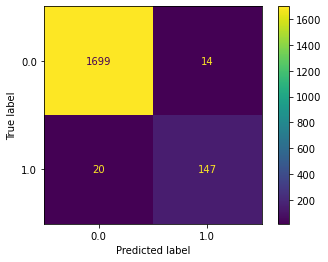

In [16]:
plot_confusion_matrix(cb_cl, lab5_cl_x_test, lab5_cl_y_test)

Видим небольшое улучшение на уровне статистической погрешности.

Попробуем рандомизированный поиск для оптимизации гиперпараметров:

In [17]:
lr_range = np.array(np.geomspace(1e-08, 1e+00, num = 9))
cb_cl_new = CatBoostClassifier(random_seed = RANDOM_STATE)
results = cb_cl_new.randomized_search({"learning_rate": lr_range}, 
                                      lab5_cl_x_train, 
                                      lab5_cl_y_train,
                                      search_by_train_test_split = False,
                                      verbose = False, 
                                      plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6931450	test: 0.6931450	best: 0.6931450 (0)
1:	learn: 0.6931428	test: 0.6931428	best: 0.6931428 (1)
2:	learn: 0.6931408	test: 0.6931409	best: 0.6931409 (2)
3:	learn: 0.6931387	test: 0.6931387	best: 0.6931387 (3)
4:	learn: 0.6931367	test: 0.6931367	best: 0.6931367 (4)
5:	learn: 0.6931345	test: 0.6931345	best: 0.6931345 (5)
6:	learn: 0.6931324	test: 0.6931325	best: 0.6931325 (6)
7:	learn: 0.6931303	test: 0.6931303	best: 0.6931303 (7)
8:	learn: 0.6931282	test: 0.6931282	best: 0.6931282 (8)
9:	learn: 0.6931261	test: 0.6931261	best: 0.6931261 (9)
10:	learn: 0.6931239	test: 0.6931239	best: 0.6931239 (10)
11:	learn: 0.6931218	test: 0.6931218	best: 0.6931218 (11)
12:	learn: 0.6931198	test: 0.6931199	best: 0.6931199 (12)	total: 358ms	remaining: 27.2s
13:	learn: 0.6931178	test: 0.6931179	best: 0.6931179 (13)
14:	learn: 0.6931156	test: 0.6931156	best: 0.6931156 (14)
15:	learn: 0.6931133	test: 0.6931133	best: 0.6931133 (15)
16:	learn: 0.6931112	test: 0.6931113	best: 0.6931113 (16)
17:	

210:	learn: 0.6927070	test: 0.6927078	best: 0.6927078 (210)
211:	learn: 0.6927049	test: 0.6927056	best: 0.6927056 (211)
212:	learn: 0.6927029	test: 0.6927036	best: 0.6927036 (212)
213:	learn: 0.6927008	test: 0.6927016	best: 0.6927016 (213)
214:	learn: 0.6926990	test: 0.6926997	best: 0.6926997 (214)
215:	learn: 0.6926968	test: 0.6926975	best: 0.6926975 (215)
216:	learn: 0.6926948	test: 0.6926956	best: 0.6926956 (216)
217:	learn: 0.6926926	test: 0.6926933	best: 0.6926933 (217)
218:	learn: 0.6926905	test: 0.6926913	best: 0.6926913 (218)
219:	learn: 0.6926884	test: 0.6926892	best: 0.6926892 (219)
220:	learn: 0.6926863	test: 0.6926870	best: 0.6926870 (220)
221:	learn: 0.6926840	test: 0.6926848	best: 0.6926848 (221)
222:	learn: 0.6926820	test: 0.6926828	best: 0.6926828 (222)
223:	learn: 0.6926799	test: 0.6926807	best: 0.6926807 (223)
224:	learn: 0.6926779	test: 0.6926787	best: 0.6926787 (224)
225:	learn: 0.6926758	test: 0.6926766	best: 0.6926766 (225)
226:	learn: 0.6926738	test: 0.6926746	be

411:	learn: 0.6922873	test: 0.6922889	best: 0.6922889 (411)
412:	learn: 0.6922852	test: 0.6922867	best: 0.6922867 (412)
413:	learn: 0.6922831	test: 0.6922847	best: 0.6922847 (413)
414:	learn: 0.6922812	test: 0.6922827	best: 0.6922827 (414)
415:	learn: 0.6922790	test: 0.6922806	best: 0.6922806 (415)
416:	learn: 0.6922770	test: 0.6922786	best: 0.6922786 (416)
417:	learn: 0.6922749	test: 0.6922765	best: 0.6922765 (417)
418:	learn: 0.6922730	test: 0.6922745	best: 0.6922745 (418)
419:	learn: 0.6922710	test: 0.6922725	best: 0.6922725 (419)
420:	learn: 0.6922687	test: 0.6922703	best: 0.6922703 (420)
421:	learn: 0.6922667	test: 0.6922682	best: 0.6922682 (421)
422:	learn: 0.6922646	test: 0.6922662	best: 0.6922662 (422)
423:	learn: 0.6922625	test: 0.6922641	best: 0.6922641 (423)
424:	learn: 0.6922606	test: 0.6922621	best: 0.6922621 (424)
425:	learn: 0.6922583	test: 0.6922599	best: 0.6922599 (425)
426:	learn: 0.6922563	test: 0.6922579	best: 0.6922579 (426)
427:	learn: 0.6922543	test: 0.6922559	be

616:	learn: 0.6918554	test: 0.6918578	best: 0.6918578 (616)
617:	learn: 0.6918533	test: 0.6918556	best: 0.6918556 (617)
618:	learn: 0.6918514	test: 0.6918538	best: 0.6918538 (618)
619:	learn: 0.6918493	test: 0.6918517	best: 0.6918517 (619)
620:	learn: 0.6918471	test: 0.6918495	best: 0.6918495 (620)
621:	learn: 0.6918451	test: 0.6918474	best: 0.6918474 (621)
622:	learn: 0.6918429	test: 0.6918453	best: 0.6918453 (622)
623:	learn: 0.6918408	test: 0.6918432	best: 0.6918432 (623)
624:	learn: 0.6918388	test: 0.6918412	best: 0.6918412 (624)
625:	learn: 0.6918366	test: 0.6918390	best: 0.6918390 (625)
626:	learn: 0.6918348	test: 0.6918372	best: 0.6918372 (626)
627:	learn: 0.6918327	test: 0.6918351	best: 0.6918351 (627)
628:	learn: 0.6918307	test: 0.6918331	best: 0.6918331 (628)
629:	learn: 0.6918287	test: 0.6918311	best: 0.6918311 (629)
630:	learn: 0.6918266	test: 0.6918290	best: 0.6918290 (630)
631:	learn: 0.6918245	test: 0.6918269	best: 0.6918269 (631)
632:	learn: 0.6918226	test: 0.6918250	be

773:	learn: 0.6915280	test: 0.6915310	best: 0.6915310 (773)
774:	learn: 0.6915259	test: 0.6915288	best: 0.6915288 (774)
775:	learn: 0.6915238	test: 0.6915268	best: 0.6915268 (775)
776:	learn: 0.6915216	test: 0.6915246	best: 0.6915246 (776)
777:	learn: 0.6915195	test: 0.6915224	best: 0.6915224 (777)
778:	learn: 0.6915174	test: 0.6915203	best: 0.6915203 (778)
779:	learn: 0.6915154	test: 0.6915184	best: 0.6915184 (779)
780:	learn: 0.6915133	test: 0.6915162	best: 0.6915162 (780)
781:	learn: 0.6915111	test: 0.6915141	best: 0.6915141 (781)
782:	learn: 0.6915091	test: 0.6915121	best: 0.6915121 (782)
783:	learn: 0.6915070	test: 0.6915100	best: 0.6915100 (783)
784:	learn: 0.6915050	test: 0.6915079	best: 0.6915079 (784)
785:	learn: 0.6915029	test: 0.6915059	best: 0.6915059 (785)
786:	learn: 0.6915009	test: 0.6915039	best: 0.6915039 (786)
787:	learn: 0.6914988	test: 0.6915018	best: 0.6915018 (787)
788:	learn: 0.6914967	test: 0.6914997	best: 0.6914997 (788)
789:	learn: 0.6914947	test: 0.6914977	be

923:	learn: 0.6912128	test: 0.6912163	best: 0.6912163 (923)
924:	learn: 0.6912108	test: 0.6912143	best: 0.6912143 (924)
925:	learn: 0.6912088	test: 0.6912123	best: 0.6912123 (925)
926:	learn: 0.6912066	test: 0.6912101	best: 0.6912101 (926)
927:	learn: 0.6912045	test: 0.6912080	best: 0.6912080 (927)
928:	learn: 0.6912025	test: 0.6912060	best: 0.6912060 (928)
929:	learn: 0.6912004	test: 0.6912039	best: 0.6912039 (929)
930:	learn: 0.6911982	test: 0.6912017	best: 0.6912017 (930)
931:	learn: 0.6911961	test: 0.6911996	best: 0.6911996 (931)
932:	learn: 0.6911941	test: 0.6911976	best: 0.6911976 (932)
933:	learn: 0.6911921	test: 0.6911956	best: 0.6911956 (933)
934:	learn: 0.6911900	test: 0.6911935	best: 0.6911935 (934)
935:	learn: 0.6911879	test: 0.6911914	best: 0.6911914 (935)
936:	learn: 0.6911857	test: 0.6911893	best: 0.6911893 (936)
937:	learn: 0.6911836	test: 0.6911871	best: 0.6911871 (937)
938:	learn: 0.6911815	test: 0.6911850	best: 0.6911850 (938)
939:	learn: 0.6911794	test: 0.6911829	be

77:	learn: 0.6915144	test: 0.6915172	best: 0.6915172 (77)
78:	learn: 0.6914939	test: 0.6914967	best: 0.6914967 (78)
79:	learn: 0.6914727	test: 0.6914755	best: 0.6914755 (79)
80:	learn: 0.6914530	test: 0.6914558	best: 0.6914558 (80)
81:	learn: 0.6914307	test: 0.6914337	best: 0.6914337 (81)
82:	learn: 0.6914119	test: 0.6914150	best: 0.6914150 (82)
83:	learn: 0.6913915	test: 0.6913946	best: 0.6913946 (83)
84:	learn: 0.6913719	test: 0.6913750	best: 0.6913750 (84)
85:	learn: 0.6913504	test: 0.6913535	best: 0.6913535 (85)
86:	learn: 0.6913294	test: 0.6913326	best: 0.6913326 (86)
87:	learn: 0.6913072	test: 0.6913104	best: 0.6913104 (87)
88:	learn: 0.6912856	test: 0.6912888	best: 0.6912888 (88)
89:	learn: 0.6912662	test: 0.6912694	best: 0.6912694 (89)
90:	learn: 0.6912441	test: 0.6912473	best: 0.6912473 (90)
91:	learn: 0.6912246	test: 0.6912279	best: 0.6912279 (91)
92:	learn: 0.6912021	test: 0.6912054	best: 0.6912054 (92)
93:	learn: 0.6911811	test: 0.6911844	best: 0.6911844 (93)
94:	learn: 0.6

281:	learn: 0.6872881	test: 0.6872983	best: 0.6872983 (281)
282:	learn: 0.6872687	test: 0.6872789	best: 0.6872789 (282)
283:	learn: 0.6872509	test: 0.6872611	best: 0.6872611 (283)
284:	learn: 0.6872310	test: 0.6872413	best: 0.6872413 (284)
285:	learn: 0.6872110	test: 0.6872214	best: 0.6872214 (285)
286:	learn: 0.6871884	test: 0.6871988	best: 0.6871988 (286)
287:	learn: 0.6871679	test: 0.6871783	best: 0.6871783 (287)
288:	learn: 0.6871475	test: 0.6871579	best: 0.6871579 (288)
289:	learn: 0.6871263	test: 0.6871367	best: 0.6871367 (289)
290:	learn: 0.6871044	test: 0.6871149	best: 0.6871149 (290)
291:	learn: 0.6870848	test: 0.6870953	best: 0.6870953 (291)
292:	learn: 0.6870643	test: 0.6870749	best: 0.6870749 (292)
293:	learn: 0.6870428	test: 0.6870534	best: 0.6870534 (293)
294:	learn: 0.6870210	test: 0.6870317	best: 0.6870317 (294)
295:	learn: 0.6869989	test: 0.6870097	best: 0.6870097 (295)
296:	learn: 0.6869799	test: 0.6869907	best: 0.6869907 (296)
297:	learn: 0.6869587	test: 0.6869695	be

456:	learn: 0.6836770	test: 0.6836943	best: 0.6836943 (456)
457:	learn: 0.6836563	test: 0.6836737	best: 0.6836737 (457)
458:	learn: 0.6836346	test: 0.6836519	best: 0.6836519 (458)
459:	learn: 0.6836135	test: 0.6836309	best: 0.6836309 (459)
460:	learn: 0.6835919	test: 0.6836092	best: 0.6836092 (460)
461:	learn: 0.6835719	test: 0.6835893	best: 0.6835893 (461)
462:	learn: 0.6835499	test: 0.6835675	best: 0.6835675 (462)
463:	learn: 0.6835290	test: 0.6835467	best: 0.6835467 (463)
464:	learn: 0.6835084	test: 0.6835262	best: 0.6835262 (464)
465:	learn: 0.6834890	test: 0.6835069	best: 0.6835069 (465)
466:	learn: 0.6834683	test: 0.6834863	best: 0.6834863 (466)
467:	learn: 0.6834478	test: 0.6834659	best: 0.6834659 (467)
468:	learn: 0.6834271	test: 0.6834453	best: 0.6834453 (468)
469:	learn: 0.6834070	test: 0.6834253	best: 0.6834253 (469)
470:	learn: 0.6833881	test: 0.6834064	best: 0.6834064 (470)
471:	learn: 0.6833663	test: 0.6833848	best: 0.6833848 (471)
472:	learn: 0.6833459	test: 0.6833644	be

672:	learn: 0.6792129	test: 0.6792391	best: 0.6792391 (672)
673:	learn: 0.6791930	test: 0.6792193	best: 0.6792193 (673)
674:	learn: 0.6791727	test: 0.6791991	best: 0.6791991 (674)
675:	learn: 0.6791539	test: 0.6791803	best: 0.6791803 (675)
676:	learn: 0.6791343	test: 0.6791607	best: 0.6791607 (676)
677:	learn: 0.6791130	test: 0.6791393	best: 0.6791393 (677)
678:	learn: 0.6790944	test: 0.6791207	best: 0.6791207 (678)
679:	learn: 0.6790732	test: 0.6790996	best: 0.6790996 (679)
680:	learn: 0.6790534	test: 0.6790798	best: 0.6790798 (680)
681:	learn: 0.6790330	test: 0.6790595	best: 0.6790595 (681)
682:	learn: 0.6790118	test: 0.6790384	best: 0.6790384 (682)
683:	learn: 0.6789901	test: 0.6790165	best: 0.6790165 (683)
684:	learn: 0.6789708	test: 0.6789973	best: 0.6789973 (684)
685:	learn: 0.6789496	test: 0.6789760	best: 0.6789760 (685)
686:	learn: 0.6789277	test: 0.6789542	best: 0.6789542 (686)
687:	learn: 0.6789065	test: 0.6789330	best: 0.6789330 (687)
688:	learn: 0.6788855	test: 0.6789121	be

840:	learn: 0.6757786	test: 0.6758100	best: 0.6758100 (840)
841:	learn: 0.6757582	test: 0.6757896	best: 0.6757896 (841)
842:	learn: 0.6757383	test: 0.6757697	best: 0.6757697 (842)
843:	learn: 0.6757172	test: 0.6757486	best: 0.6757486 (843)
844:	learn: 0.6756970	test: 0.6757285	best: 0.6757285 (844)
845:	learn: 0.6756762	test: 0.6757078	best: 0.6757078 (845)
846:	learn: 0.6756558	test: 0.6756874	best: 0.6756874 (846)
847:	learn: 0.6756360	test: 0.6756675	best: 0.6756675 (847)
848:	learn: 0.6756150	test: 0.6756464	best: 0.6756464 (848)
849:	learn: 0.6755929	test: 0.6756244	best: 0.6756244 (849)
850:	learn: 0.6755713	test: 0.6756028	best: 0.6756028 (850)
851:	learn: 0.6755513	test: 0.6755829	best: 0.6755829 (851)
852:	learn: 0.6755301	test: 0.6755619	best: 0.6755619 (852)
853:	learn: 0.6755093	test: 0.6755410	best: 0.6755410 (853)
854:	learn: 0.6754880	test: 0.6755198	best: 0.6755198 (854)
855:	learn: 0.6754680	test: 0.6754998	best: 0.6754998 (855)
856:	learn: 0.6754476	test: 0.6754795	be

0:	learn: 0.6929271	test: 0.6929271	best: 0.6929271 (0)
1:	learn: 0.6927102	test: 0.6927107	best: 0.6927107 (1)
2:	learn: 0.6925132	test: 0.6925145	best: 0.6925145 (2)
3:	learn: 0.6923015	test: 0.6923032	best: 0.6923032 (3)
4:	learn: 0.6920998	test: 0.6921015	best: 0.6921015 (4)
5:	learn: 0.6918782	test: 0.6918802	best: 0.6918802 (5)
6:	learn: 0.6916734	test: 0.6916759	best: 0.6916759 (6)
7:	learn: 0.6914581	test: 0.6914610	best: 0.6914610 (7)
8:	learn: 0.6912492	test: 0.6912522	best: 0.6912522 (8)
9:	learn: 0.6910417	test: 0.6910450	best: 0.6910450 (9)
10:	learn: 0.6908225	test: 0.6908267	best: 0.6908267 (10)
11:	learn: 0.6906125	test: 0.6906172	best: 0.6906172 (11)
12:	learn: 0.6904186	test: 0.6904235	best: 0.6904235 (12)
13:	learn: 0.6902158	test: 0.6902210	best: 0.6902210 (13)
14:	learn: 0.6899927	test: 0.6899987	best: 0.6899987 (14)
15:	learn: 0.6897649	test: 0.6897713	best: 0.6897713 (15)
16:	learn: 0.6895606	test: 0.6895673	best: 0.6895673 (16)
17:	learn: 0.6893521	test: 0.68935

161:	learn: 0.6602269	test: 0.6602866	best: 0.6602866 (161)
162:	learn: 0.6600405	test: 0.6601004	best: 0.6601004 (162)
163:	learn: 0.6598341	test: 0.6598954	best: 0.6598954 (163)
164:	learn: 0.6596371	test: 0.6596987	best: 0.6596987 (164)
165:	learn: 0.6594436	test: 0.6595057	best: 0.6595057 (165)
166:	learn: 0.6592616	test: 0.6593240	best: 0.6593240 (166)
167:	learn: 0.6590598	test: 0.6591226	best: 0.6591226 (167)
168:	learn: 0.6588618	test: 0.6589248	best: 0.6589248 (168)
169:	learn: 0.6586564	test: 0.6587197	best: 0.6587197 (169)
170:	learn: 0.6584633	test: 0.6585263	best: 0.6585263 (170)
171:	learn: 0.6582543	test: 0.6583176	best: 0.6583176 (171)
172:	learn: 0.6580676	test: 0.6581312	best: 0.6581312 (172)
173:	learn: 0.6578593	test: 0.6579226	best: 0.6579226 (173)
174:	learn: 0.6576590	test: 0.6577227	best: 0.6577227 (174)
175:	learn: 0.6574721	test: 0.6575361	best: 0.6575361 (175)
176:	learn: 0.6572650	test: 0.6573294	best: 0.6573294 (176)
177:	learn: 0.6570698	test: 0.6571345	be

357:	learn: 0.6227349	test: 0.6228652	best: 0.6228652 (357)
358:	learn: 0.6225422	test: 0.6226729	best: 0.6226729 (358)
359:	learn: 0.6223619	test: 0.6224928	best: 0.6224928 (359)
360:	learn: 0.6221684	test: 0.6223000	best: 0.6223000 (360)
361:	learn: 0.6220009	test: 0.6221325	best: 0.6221325 (361)
362:	learn: 0.6218120	test: 0.6219438	best: 0.6219438 (362)
363:	learn: 0.6216298	test: 0.6217621	best: 0.6217621 (363)
364:	learn: 0.6214338	test: 0.6215664	best: 0.6215664 (364)
365:	learn: 0.6212546	test: 0.6213878	best: 0.6213878 (365)
366:	learn: 0.6210601	test: 0.6211934	best: 0.6211934 (366)
367:	learn: 0.6208817	test: 0.6210158	best: 0.6210158 (367)
368:	learn: 0.6207127	test: 0.6208473	best: 0.6208473 (368)
369:	learn: 0.6205174	test: 0.6206523	best: 0.6206523 (369)
370:	learn: 0.6203280	test: 0.6204630	best: 0.6204630 (370)
371:	learn: 0.6201413	test: 0.6202767	best: 0.6202767 (371)
372:	learn: 0.6199512	test: 0.6200868	best: 0.6200868 (372)
373:	learn: 0.6197716	test: 0.6199072	be

531:	learn: 0.5912308	test: 0.5914307	best: 0.5914307 (531)
532:	learn: 0.5910590	test: 0.5912582	best: 0.5912582 (532)
533:	learn: 0.5908786	test: 0.5910788	best: 0.5910788 (533)
534:	learn: 0.5907108	test: 0.5909118	best: 0.5909118 (534)
535:	learn: 0.5905397	test: 0.5907415	best: 0.5907415 (535)
536:	learn: 0.5903733	test: 0.5905755	best: 0.5905755 (536)
537:	learn: 0.5901944	test: 0.5903976	best: 0.5903976 (537)
538:	learn: 0.5900195	test: 0.5902235	best: 0.5902235 (538)
539:	learn: 0.5898360	test: 0.5900400	best: 0.5900400 (539)
540:	learn: 0.5896493	test: 0.5898530	best: 0.5898530 (540)
541:	learn: 0.5894685	test: 0.5896731	best: 0.5896731 (541)
542:	learn: 0.5892941	test: 0.5894989	best: 0.5894989 (542)
543:	learn: 0.5891212	test: 0.5893259	best: 0.5893259 (543)
544:	learn: 0.5889485	test: 0.5891529	best: 0.5891529 (544)
545:	learn: 0.5887655	test: 0.5889692	best: 0.5889692 (545)
546:	learn: 0.5885904	test: 0.5887944	best: 0.5887944 (546)
547:	learn: 0.5884218	test: 0.5886263	be

739:	learn: 0.5560093	test: 0.5562813	best: 0.5562813 (739)
740:	learn: 0.5558424	test: 0.5561157	best: 0.5561157 (740)
741:	learn: 0.5556745	test: 0.5559486	best: 0.5559486 (741)
742:	learn: 0.5555175	test: 0.5557926	best: 0.5557926 (742)
743:	learn: 0.5553470	test: 0.5556221	best: 0.5556221 (743)
744:	learn: 0.5551900	test: 0.5554660	best: 0.5554660 (744)
745:	learn: 0.5550344	test: 0.5553105	best: 0.5553105 (745)
746:	learn: 0.5548723	test: 0.5551490	best: 0.5551490 (746)
747:	learn: 0.5547154	test: 0.5549922	best: 0.5549922 (747)
748:	learn: 0.5545580	test: 0.5548355	best: 0.5548355 (748)
749:	learn: 0.5543942	test: 0.5546728	best: 0.5546728 (749)
750:	learn: 0.5542378	test: 0.5545164	best: 0.5545164 (750)
751:	learn: 0.5540768	test: 0.5543553	best: 0.5543553 (751)
752:	learn: 0.5539037	test: 0.5541820	best: 0.5541820 (752)
753:	learn: 0.5537441	test: 0.5540226	best: 0.5540226 (753)
754:	learn: 0.5535828	test: 0.5538616	best: 0.5538616 (754)
755:	learn: 0.5534300	test: 0.5537093	be

932:	learn: 0.5254477	test: 0.5257777	best: 0.5257777 (932)
933:	learn: 0.5253061	test: 0.5256368	best: 0.5256368 (933)
934:	learn: 0.5251450	test: 0.5254759	best: 0.5254759 (934)
935:	learn: 0.5249942	test: 0.5253249	best: 0.5253249 (935)
936:	learn: 0.5248355	test: 0.5251674	best: 0.5251674 (936)
937:	learn: 0.5246816	test: 0.5250140	best: 0.5250140 (937)
938:	learn: 0.5245434	test: 0.5248765	best: 0.5248765 (938)
939:	learn: 0.5243944	test: 0.5247282	best: 0.5247282 (939)
940:	learn: 0.5242327	test: 0.5245670	best: 0.5245670 (940)
941:	learn: 0.5240851	test: 0.5244196	best: 0.5244196 (941)
942:	learn: 0.5239292	test: 0.5242638	best: 0.5242638 (942)
943:	learn: 0.5237700	test: 0.5241047	best: 0.5241047 (943)
944:	learn: 0.5236192	test: 0.5239542	best: 0.5239542 (944)
945:	learn: 0.5234660	test: 0.5238016	best: 0.5238016 (945)
946:	learn: 0.5233003	test: 0.5236365	best: 0.5236365 (946)
947:	learn: 0.5231508	test: 0.5234873	best: 0.5234873 (947)
948:	learn: 0.5230001	test: 0.5233364	be

96:	learn: 0.5203640	test: 0.5207002	best: 0.5207002 (96)
97:	learn: 0.5189807	test: 0.5193183	best: 0.5193183 (97)
98:	learn: 0.5175922	test: 0.5179355	best: 0.5179355 (98)
99:	learn: 0.5161273	test: 0.5164756	best: 0.5164756 (99)
100:	learn: 0.5146742	test: 0.5150263	best: 0.5150263 (100)
101:	learn: 0.5131781	test: 0.5135426	best: 0.5135426 (101)
102:	learn: 0.5117806	test: 0.5121554	best: 0.5121554 (102)
103:	learn: 0.5101633	test: 0.5105418	best: 0.5105418 (103)
104:	learn: 0.5088565	test: 0.5092413	best: 0.5092413 (104)
105:	learn: 0.5073990	test: 0.5077865	best: 0.5077865 (105)
106:	learn: 0.5058363	test: 0.5062275	best: 0.5062275 (106)
107:	learn: 0.5043135	test: 0.5047097	best: 0.5047097 (107)
108:	learn: 0.5029007	test: 0.5032989	best: 0.5032989 (108)
109:	learn: 0.5014583	test: 0.5018624	best: 0.5018624 (109)
110:	learn: 0.5000792	test: 0.5004887	best: 0.5004887 (110)
111:	learn: 0.4987394	test: 0.4991502	best: 0.4991502 (111)
112:	learn: 0.4973358	test: 0.4977471	best: 0.49

239:	learn: 0.3522258	test: 0.3530633	best: 0.3530633 (239)
240:	learn: 0.3513210	test: 0.3521599	best: 0.3521599 (240)
241:	learn: 0.3503417	test: 0.3511836	best: 0.3511836 (241)
242:	learn: 0.3493977	test: 0.3502444	best: 0.3502444 (242)
243:	learn: 0.3485183	test: 0.3493670	best: 0.3493670 (243)
244:	learn: 0.3476133	test: 0.3484611	best: 0.3484611 (244)
245:	learn: 0.3467523	test: 0.3476006	best: 0.3476006 (245)
246:	learn: 0.3458444	test: 0.3466960	best: 0.3466960 (246)
247:	learn: 0.3449793	test: 0.3458316	best: 0.3458316 (247)
248:	learn: 0.3441255	test: 0.3449792	best: 0.3449792 (248)
249:	learn: 0.3432883	test: 0.3441459	best: 0.3441459 (249)
250:	learn: 0.3424181	test: 0.3432770	best: 0.3432770 (250)
251:	learn: 0.3415473	test: 0.3424116	best: 0.3424116 (251)
252:	learn: 0.3406632	test: 0.3415281	best: 0.3415281 (252)
253:	learn: 0.3397401	test: 0.3406050	best: 0.3406050 (253)
254:	learn: 0.3389174	test: 0.3397853	best: 0.3397853 (254)
255:	learn: 0.3380088	test: 0.3388772	be

395:	learn: 0.2445361	test: 0.2457978	best: 0.2457978 (395)
396:	learn: 0.2440582	test: 0.2453224	best: 0.2453224 (396)
397:	learn: 0.2435424	test: 0.2448099	best: 0.2448099 (397)
398:	learn: 0.2430155	test: 0.2442849	best: 0.2442849 (398)
399:	learn: 0.2425277	test: 0.2438005	best: 0.2438005 (399)
400:	learn: 0.2420091	test: 0.2432830	best: 0.2432830 (400)
401:	learn: 0.2415036	test: 0.2427820	best: 0.2427820 (401)
402:	learn: 0.2410023	test: 0.2422821	best: 0.2422821 (402)
403:	learn: 0.2404869	test: 0.2417690	best: 0.2417690 (403)
404:	learn: 0.2399611	test: 0.2412439	best: 0.2412439 (404)
405:	learn: 0.2394695	test: 0.2407544	best: 0.2407544 (405)
406:	learn: 0.2389617	test: 0.2402491	best: 0.2402491 (406)
407:	learn: 0.2384762	test: 0.2397663	best: 0.2397663 (407)
408:	learn: 0.2379643	test: 0.2392570	best: 0.2392570 (408)
409:	learn: 0.2374780	test: 0.2387704	best: 0.2387704 (409)
410:	learn: 0.2370065	test: 0.2383007	best: 0.2383007 (410)
411:	learn: 0.2365057	test: 0.2378022	be

538:	learn: 0.1857816	test: 0.1874148	best: 0.1874148 (538)
539:	learn: 0.1854576	test: 0.1870954	best: 0.1870954 (539)
540:	learn: 0.1851175	test: 0.1867553	best: 0.1867553 (540)
541:	learn: 0.1847873	test: 0.1864289	best: 0.1864289 (541)
542:	learn: 0.1844856	test: 0.1861307	best: 0.1861307 (542)
543:	learn: 0.1841795	test: 0.1858252	best: 0.1858252 (543)
544:	learn: 0.1838595	test: 0.1855062	best: 0.1855062 (544)
545:	learn: 0.1835485	test: 0.1851969	best: 0.1851969 (545)
546:	learn: 0.1832395	test: 0.1848900	best: 0.1848900 (546)
547:	learn: 0.1829473	test: 0.1845988	best: 0.1845988 (547)
548:	learn: 0.1826534	test: 0.1843086	best: 0.1843086 (548)
549:	learn: 0.1823442	test: 0.1840038	best: 0.1840038 (549)
550:	learn: 0.1820655	test: 0.1837233	best: 0.1837233 (550)
551:	learn: 0.1817362	test: 0.1833973	best: 0.1833973 (551)
552:	learn: 0.1814114	test: 0.1830756	best: 0.1830756 (552)
553:	learn: 0.1811278	test: 0.1827965	best: 0.1827965 (553)
554:	learn: 0.1808363	test: 0.1825093	be

756:	learn: 0.1361156	test: 0.1384147	best: 0.1384147 (756)
757:	learn: 0.1359594	test: 0.1382616	best: 0.1382616 (757)
758:	learn: 0.1358167	test: 0.1381230	best: 0.1381230 (758)
759:	learn: 0.1356501	test: 0.1379616	best: 0.1379616 (759)
760:	learn: 0.1354763	test: 0.1377931	best: 0.1377931 (760)
761:	learn: 0.1353086	test: 0.1376309	best: 0.1376309 (761)
762:	learn: 0.1351485	test: 0.1374745	best: 0.1374745 (762)
763:	learn: 0.1349807	test: 0.1373102	best: 0.1373102 (763)
764:	learn: 0.1348168	test: 0.1371503	best: 0.1371503 (764)
765:	learn: 0.1346552	test: 0.1369924	best: 0.1369924 (765)
766:	learn: 0.1344856	test: 0.1368276	best: 0.1368276 (766)
767:	learn: 0.1343234	test: 0.1366702	best: 0.1366702 (767)
768:	learn: 0.1341660	test: 0.1365190	best: 0.1365190 (768)
769:	learn: 0.1340155	test: 0.1363745	best: 0.1363745 (769)
770:	learn: 0.1338684	test: 0.1362312	best: 0.1362312 (770)
771:	learn: 0.1337051	test: 0.1360687	best: 0.1360687 (771)
772:	learn: 0.1335554	test: 0.1359207	be

905:	learn: 0.1168058	test: 0.1195983	best: 0.1195983 (905)
906:	learn: 0.1166971	test: 0.1194935	best: 0.1194935 (906)
907:	learn: 0.1165926	test: 0.1193946	best: 0.1193946 (907)
908:	learn: 0.1164786	test: 0.1192872	best: 0.1192872 (908)
909:	learn: 0.1163744	test: 0.1191890	best: 0.1191890 (909)
910:	learn: 0.1162727	test: 0.1190902	best: 0.1190902 (910)
911:	learn: 0.1161699	test: 0.1189914	best: 0.1189914 (911)
912:	learn: 0.1160742	test: 0.1188997	best: 0.1188997 (912)
913:	learn: 0.1159759	test: 0.1188064	best: 0.1188064 (913)
914:	learn: 0.1158748	test: 0.1187089	best: 0.1187089 (914)
915:	learn: 0.1157690	test: 0.1186080	best: 0.1186080 (915)
916:	learn: 0.1156610	test: 0.1185035	best: 0.1185035 (916)
917:	learn: 0.1155623	test: 0.1184096	best: 0.1184096 (917)
918:	learn: 0.1154660	test: 0.1183178	best: 0.1183178 (918)
919:	learn: 0.1153709	test: 0.1182251	best: 0.1182251 (919)
920:	learn: 0.1152740	test: 0.1181331	best: 0.1181331 (920)
921:	learn: 0.1151816	test: 0.1180406	be

113:	learn: 0.0985876	test: 0.1023487	best: 0.1023487 (113)
114:	learn: 0.0980620	test: 0.1018538	best: 0.1018538 (114)
115:	learn: 0.0975236	test: 0.1013340	best: 0.1013340 (115)
116:	learn: 0.0968962	test: 0.1007415	best: 0.1007415 (116)
117:	learn: 0.0963195	test: 0.1002114	best: 0.1002114 (117)
118:	learn: 0.0958165	test: 0.0997467	best: 0.0997467 (118)
119:	learn: 0.0952860	test: 0.0992631	best: 0.0992631 (119)
120:	learn: 0.0948331	test: 0.0988456	best: 0.0988456 (120)
121:	learn: 0.0944056	test: 0.0984556	best: 0.0984556 (121)
122:	learn: 0.0938890	test: 0.0979816	best: 0.0979816 (122)
123:	learn: 0.0934425	test: 0.0975810	best: 0.0975810 (123)
124:	learn: 0.0929485	test: 0.0971216	best: 0.0971216 (124)
125:	learn: 0.0923711	test: 0.0965826	best: 0.0965826 (125)
126:	learn: 0.0919093	test: 0.0961638	best: 0.0961638 (126)
127:	learn: 0.0914622	test: 0.0957633	best: 0.0957633 (127)
128:	learn: 0.0910166	test: 0.0953671	best: 0.0953671 (128)
129:	learn: 0.0906146	test: 0.0950126	be

254:	learn: 0.0686199	test: 0.0777061	best: 0.0777061 (254)
255:	learn: 0.0685510	test: 0.0776624	best: 0.0776624 (255)
256:	learn: 0.0684948	test: 0.0776352	best: 0.0776352 (256)
257:	learn: 0.0684245	test: 0.0775948	best: 0.0775948 (257)
258:	learn: 0.0683537	test: 0.0775370	best: 0.0775370 (258)
259:	learn: 0.0682643	test: 0.0774814	best: 0.0774814 (259)
260:	learn: 0.0681876	test: 0.0774380	best: 0.0774380 (260)
261:	learn: 0.0681023	test: 0.0773905	best: 0.0773905 (261)
262:	learn: 0.0680080	test: 0.0773411	best: 0.0773411 (262)
263:	learn: 0.0679561	test: 0.0773231	best: 0.0773231 (263)
264:	learn: 0.0678893	test: 0.0773044	best: 0.0773044 (264)
265:	learn: 0.0678371	test: 0.0772741	best: 0.0772741 (265)
266:	learn: 0.0677613	test: 0.0772413	best: 0.0772413 (266)
267:	learn: 0.0677006	test: 0.0772154	best: 0.0772154 (267)
268:	learn: 0.0676526	test: 0.0771852	best: 0.0771852 (268)
269:	learn: 0.0675971	test: 0.0771595	best: 0.0771595 (269)
270:	learn: 0.0675433	test: 0.0771429	be

393:	learn: 0.0616871	test: 0.0751121	best: 0.0751121 (393)
394:	learn: 0.0616391	test: 0.0751063	best: 0.0751063 (394)
395:	learn: 0.0616000	test: 0.0751018	best: 0.0751018 (395)
396:	learn: 0.0615592	test: 0.0750996	best: 0.0750996 (396)
397:	learn: 0.0615241	test: 0.0750982	best: 0.0750982 (397)
398:	learn: 0.0614770	test: 0.0751088	best: 0.0750982 (397)
399:	learn: 0.0614202	test: 0.0751056	best: 0.0750982 (397)
400:	learn: 0.0613749	test: 0.0751145	best: 0.0750982 (397)
401:	learn: 0.0613353	test: 0.0751081	best: 0.0750982 (397)
402:	learn: 0.0612925	test: 0.0750994	best: 0.0750982 (397)
403:	learn: 0.0612576	test: 0.0750872	best: 0.0750872 (403)
404:	learn: 0.0612173	test: 0.0750730	best: 0.0750730 (404)
405:	learn: 0.0611883	test: 0.0750610	best: 0.0750610 (405)
406:	learn: 0.0611509	test: 0.0750491	best: 0.0750491 (406)
407:	learn: 0.0611193	test: 0.0750443	best: 0.0750443 (407)
408:	learn: 0.0610784	test: 0.0750304	best: 0.0750304 (408)
409:	learn: 0.0610532	test: 0.0750291	be

535:	learn: 0.0570028	test: 0.0743361	best: 0.0743361 (535)
536:	learn: 0.0569728	test: 0.0743337	best: 0.0743337 (536)
537:	learn: 0.0569410	test: 0.0743297	best: 0.0743297 (537)
538:	learn: 0.0569049	test: 0.0743284	best: 0.0743284 (538)
539:	learn: 0.0568788	test: 0.0743217	best: 0.0743217 (539)
540:	learn: 0.0568510	test: 0.0743193	best: 0.0743193 (540)
541:	learn: 0.0568232	test: 0.0743138	best: 0.0743138 (541)
542:	learn: 0.0567921	test: 0.0743192	best: 0.0743138 (541)
543:	learn: 0.0567630	test: 0.0743180	best: 0.0743138 (541)
544:	learn: 0.0567332	test: 0.0743138	best: 0.0743138 (544)
545:	learn: 0.0566998	test: 0.0743156	best: 0.0743138 (544)
546:	learn: 0.0566760	test: 0.0743153	best: 0.0743138 (544)
547:	learn: 0.0566423	test: 0.0743095	best: 0.0743095 (547)
548:	learn: 0.0566226	test: 0.0743061	best: 0.0743061 (548)
549:	learn: 0.0565910	test: 0.0743056	best: 0.0743056 (549)
550:	learn: 0.0565732	test: 0.0743010	best: 0.0743010 (550)
551:	learn: 0.0565389	test: 0.0742930	be

679:	learn: 0.0531029	test: 0.0739198	best: 0.0739128 (678)
680:	learn: 0.0530883	test: 0.0739132	best: 0.0739128 (678)
681:	learn: 0.0530633	test: 0.0739029	best: 0.0739029 (681)
682:	learn: 0.0530312	test: 0.0738972	best: 0.0738972 (682)
683:	learn: 0.0529940	test: 0.0738954	best: 0.0738954 (683)
684:	learn: 0.0529619	test: 0.0738923	best: 0.0738923 (684)
685:	learn: 0.0529344	test: 0.0738937	best: 0.0738923 (684)
686:	learn: 0.0529090	test: 0.0738840	best: 0.0738840 (686)
687:	learn: 0.0528802	test: 0.0738771	best: 0.0738771 (687)
688:	learn: 0.0528497	test: 0.0738762	best: 0.0738762 (688)
689:	learn: 0.0528188	test: 0.0738725	best: 0.0738725 (689)
690:	learn: 0.0527924	test: 0.0738639	best: 0.0738639 (690)
691:	learn: 0.0527714	test: 0.0738651	best: 0.0738639 (690)
692:	learn: 0.0527388	test: 0.0738755	best: 0.0738639 (690)
693:	learn: 0.0527151	test: 0.0738780	best: 0.0738639 (690)
694:	learn: 0.0526913	test: 0.0738722	best: 0.0738639 (690)
695:	learn: 0.0526714	test: 0.0738684	be

823:	learn: 0.0495891	test: 0.0736750	best: 0.0736710 (803)
824:	learn: 0.0495549	test: 0.0736703	best: 0.0736703 (824)
825:	learn: 0.0495334	test: 0.0736676	best: 0.0736676 (825)
826:	learn: 0.0495100	test: 0.0736706	best: 0.0736676 (825)
827:	learn: 0.0494773	test: 0.0736713	best: 0.0736676 (825)
828:	learn: 0.0494547	test: 0.0736736	best: 0.0736676 (825)
829:	learn: 0.0494338	test: 0.0736752	best: 0.0736676 (825)
830:	learn: 0.0494039	test: 0.0736686	best: 0.0736676 (825)
831:	learn: 0.0493843	test: 0.0736648	best: 0.0736648 (831)
832:	learn: 0.0493593	test: 0.0736663	best: 0.0736648 (831)
833:	learn: 0.0493378	test: 0.0736651	best: 0.0736648 (831)
834:	learn: 0.0493170	test: 0.0736678	best: 0.0736648 (831)
835:	learn: 0.0492844	test: 0.0736706	best: 0.0736648 (831)
836:	learn: 0.0492616	test: 0.0736729	best: 0.0736648 (831)
837:	learn: 0.0492455	test: 0.0736753	best: 0.0736648 (831)
838:	learn: 0.0492304	test: 0.0736756	best: 0.0736648 (831)
839:	learn: 0.0492171	test: 0.0736716	be

961:	learn: 0.0467640	test: 0.0736504	best: 0.0736297 (952)
962:	learn: 0.0467482	test: 0.0736478	best: 0.0736297 (952)
963:	learn: 0.0467316	test: 0.0736448	best: 0.0736297 (952)
964:	learn: 0.0467090	test: 0.0736431	best: 0.0736297 (952)
965:	learn: 0.0466959	test: 0.0736443	best: 0.0736297 (952)
966:	learn: 0.0466726	test: 0.0736473	best: 0.0736297 (952)
967:	learn: 0.0466570	test: 0.0736458	best: 0.0736297 (952)
968:	learn: 0.0466417	test: 0.0736455	best: 0.0736297 (952)
969:	learn: 0.0466145	test: 0.0736478	best: 0.0736297 (952)
970:	learn: 0.0465997	test: 0.0736490	best: 0.0736297 (952)
971:	learn: 0.0465810	test: 0.0736503	best: 0.0736297 (952)
972:	learn: 0.0465632	test: 0.0736450	best: 0.0736297 (952)
973:	learn: 0.0465461	test: 0.0736431	best: 0.0736297 (952)
974:	learn: 0.0465279	test: 0.0736475	best: 0.0736297 (952)
975:	learn: 0.0465110	test: 0.0736514	best: 0.0736297 (952)
976:	learn: 0.0464834	test: 0.0736552	best: 0.0736297 (952)
977:	learn: 0.0464702	test: 0.0736559	be

117:	learn: 0.0438083	test: 0.0740879	best: 0.0739366 (104)
118:	learn: 0.0436480	test: 0.0741432	best: 0.0739366 (104)
119:	learn: 0.0434193	test: 0.0741287	best: 0.0739366 (104)
120:	learn: 0.0433168	test: 0.0741018	best: 0.0739366 (104)
121:	learn: 0.0431949	test: 0.0741219	best: 0.0739366 (104)
122:	learn: 0.0430777	test: 0.0741395	best: 0.0739366 (104)
123:	learn: 0.0428179	test: 0.0742010	best: 0.0739366 (104)
124:	learn: 0.0426978	test: 0.0741957	best: 0.0739366 (104)
125:	learn: 0.0426249	test: 0.0741876	best: 0.0739366 (104)
126:	learn: 0.0425658	test: 0.0741907	best: 0.0739366 (104)
127:	learn: 0.0423912	test: 0.0742701	best: 0.0739366 (104)
128:	learn: 0.0421894	test: 0.0743122	best: 0.0739366 (104)
129:	learn: 0.0420732	test: 0.0743255	best: 0.0739366 (104)
130:	learn: 0.0419331	test: 0.0743313	best: 0.0739366 (104)
131:	learn: 0.0418119	test: 0.0743102	best: 0.0739366 (104)
132:	learn: 0.0416270	test: 0.0743230	best: 0.0739366 (104)
133:	learn: 0.0414157	test: 0.0742768	be

269:	learn: 0.0241332	test: 0.0763452	best: 0.0739366 (104)
270:	learn: 0.0240871	test: 0.0763544	best: 0.0739366 (104)
271:	learn: 0.0240043	test: 0.0763602	best: 0.0739366 (104)
272:	learn: 0.0239180	test: 0.0763500	best: 0.0739366 (104)
273:	learn: 0.0238550	test: 0.0763715	best: 0.0739366 (104)
274:	learn: 0.0238106	test: 0.0763766	best: 0.0739366 (104)
275:	learn: 0.0236244	test: 0.0764798	best: 0.0739366 (104)
276:	learn: 0.0235320	test: 0.0764837	best: 0.0739366 (104)
277:	learn: 0.0234349	test: 0.0764783	best: 0.0739366 (104)
278:	learn: 0.0233097	test: 0.0764486	best: 0.0739366 (104)
279:	learn: 0.0231934	test: 0.0765061	best: 0.0739366 (104)
280:	learn: 0.0231066	test: 0.0765242	best: 0.0739366 (104)
281:	learn: 0.0229986	test: 0.0765824	best: 0.0739366 (104)
282:	learn: 0.0229596	test: 0.0765828	best: 0.0739366 (104)
283:	learn: 0.0228922	test: 0.0766484	best: 0.0739366 (104)
284:	learn: 0.0227945	test: 0.0766558	best: 0.0739366 (104)
285:	learn: 0.0227104	test: 0.0766713	be

435:	learn: 0.0137420	test: 0.0801388	best: 0.0739366 (104)
436:	learn: 0.0137121	test: 0.0801772	best: 0.0739366 (104)
437:	learn: 0.0136654	test: 0.0802279	best: 0.0739366 (104)
438:	learn: 0.0136141	test: 0.0803165	best: 0.0739366 (104)
439:	learn: 0.0135792	test: 0.0803227	best: 0.0739366 (104)
440:	learn: 0.0134953	test: 0.0803285	best: 0.0739366 (104)
441:	learn: 0.0134437	test: 0.0803512	best: 0.0739366 (104)
442:	learn: 0.0134220	test: 0.0803724	best: 0.0739366 (104)
443:	learn: 0.0133564	test: 0.0804857	best: 0.0739366 (104)
444:	learn: 0.0133320	test: 0.0805007	best: 0.0739366 (104)
445:	learn: 0.0132997	test: 0.0805075	best: 0.0739366 (104)
446:	learn: 0.0132578	test: 0.0805139	best: 0.0739366 (104)
447:	learn: 0.0132026	test: 0.0805765	best: 0.0739366 (104)
448:	learn: 0.0131551	test: 0.0806285	best: 0.0739366 (104)
449:	learn: 0.0131020	test: 0.0806704	best: 0.0739366 (104)
450:	learn: 0.0130630	test: 0.0807238	best: 0.0739366 (104)
451:	learn: 0.0130052	test: 0.0807578	be

637:	learn: 0.0080696	test: 0.0849176	best: 0.0739366 (104)
638:	learn: 0.0080534	test: 0.0849473	best: 0.0739366 (104)
639:	learn: 0.0080325	test: 0.0849822	best: 0.0739366 (104)
640:	learn: 0.0080179	test: 0.0849639	best: 0.0739366 (104)
641:	learn: 0.0079930	test: 0.0850196	best: 0.0739366 (104)
642:	learn: 0.0079662	test: 0.0850917	best: 0.0739366 (104)
643:	learn: 0.0079485	test: 0.0851633	best: 0.0739366 (104)
644:	learn: 0.0079374	test: 0.0852062	best: 0.0739366 (104)
645:	learn: 0.0079130	test: 0.0852661	best: 0.0739366 (104)
646:	learn: 0.0079001	test: 0.0853074	best: 0.0739366 (104)
647:	learn: 0.0078820	test: 0.0853249	best: 0.0739366 (104)
648:	learn: 0.0078637	test: 0.0853543	best: 0.0739366 (104)
649:	learn: 0.0078495	test: 0.0853621	best: 0.0739366 (104)
650:	learn: 0.0078348	test: 0.0853941	best: 0.0739366 (104)
651:	learn: 0.0078161	test: 0.0853953	best: 0.0739366 (104)
652:	learn: 0.0078053	test: 0.0854189	best: 0.0739366 (104)
653:	learn: 0.0077866	test: 0.0854228	be

838:	learn: 0.0055255	test: 0.0891409	best: 0.0739366 (104)
839:	learn: 0.0055163	test: 0.0891543	best: 0.0739366 (104)
840:	learn: 0.0055100	test: 0.0891664	best: 0.0739366 (104)
841:	learn: 0.0055006	test: 0.0891827	best: 0.0739366 (104)
842:	learn: 0.0054965	test: 0.0891799	best: 0.0739366 (104)
843:	learn: 0.0054900	test: 0.0892193	best: 0.0739366 (104)
844:	learn: 0.0054856	test: 0.0892317	best: 0.0739366 (104)
845:	learn: 0.0054754	test: 0.0892651	best: 0.0739366 (104)
846:	learn: 0.0054695	test: 0.0892731	best: 0.0739366 (104)
847:	learn: 0.0054609	test: 0.0892884	best: 0.0739366 (104)
848:	learn: 0.0054511	test: 0.0893252	best: 0.0739366 (104)
849:	learn: 0.0054441	test: 0.0893359	best: 0.0739366 (104)
850:	learn: 0.0054314	test: 0.0893955	best: 0.0739366 (104)
851:	learn: 0.0054216	test: 0.0894288	best: 0.0739366 (104)
852:	learn: 0.0054163	test: 0.0894478	best: 0.0739366 (104)
853:	learn: 0.0054089	test: 0.0894660	best: 0.0739366 (104)
854:	learn: 0.0054051	test: 0.0894829	be

0:	learn: 0.1049491	test: 0.1062783	best: 0.1062783 (0)
1:	learn: 0.0828572	test: 0.0887466	best: 0.0887466 (1)
2:	learn: 0.0769890	test: 0.0866978	best: 0.0866978 (2)
3:	learn: 0.0730948	test: 0.0865752	best: 0.0865752 (3)
4:	learn: 0.0689548	test: 0.0863082	best: 0.0863082 (4)
5:	learn: 0.0659820	test: 0.0880509	best: 0.0863082 (4)
6:	learn: 0.0630789	test: 0.0891952	best: 0.0863082 (4)
7:	learn: 0.0605052	test: 0.0907884	best: 0.0863082 (4)
8:	learn: 0.0584793	test: 0.0916947	best: 0.0863082 (4)
9:	learn: 0.0551279	test: 0.0916854	best: 0.0863082 (4)
10:	learn: 0.0521649	test: 0.0928119	best: 0.0863082 (4)
11:	learn: 0.0497649	test: 0.0934317	best: 0.0863082 (4)
12:	learn: 0.0485515	test: 0.0930221	best: 0.0863082 (4)
13:	learn: 0.0475552	test: 0.0938527	best: 0.0863082 (4)
14:	learn: 0.0457306	test: 0.0944432	best: 0.0863082 (4)
15:	learn: 0.0441911	test: 0.0952367	best: 0.0863082 (4)
16:	learn: 0.0427621	test: 0.0953607	best: 0.0863082 (4)
17:	learn: 0.0405611	test: 0.0967144	best

195:	learn: 0.0016313	test: 0.1277803	best: 0.0863082 (4)
196:	learn: 0.0016313	test: 0.1277811	best: 0.0863082 (4)
197:	learn: 0.0016313	test: 0.1277815	best: 0.0863082 (4)
198:	learn: 0.0016313	test: 0.1277820	best: 0.0863082 (4)
199:	learn: 0.0016312	test: 0.1277846	best: 0.0863082 (4)
200:	learn: 0.0016312	test: 0.1277858	best: 0.0863082 (4)
201:	learn: 0.0016311	test: 0.1277893	best: 0.0863082 (4)
202:	learn: 0.0016311	test: 0.1277912	best: 0.0863082 (4)
203:	learn: 0.0016310	test: 0.1277919	best: 0.0863082 (4)
204:	learn: 0.0016310	test: 0.1277926	best: 0.0863082 (4)
205:	learn: 0.0016310	test: 0.1277920	best: 0.0863082 (4)
206:	learn: 0.0016310	test: 0.1277919	best: 0.0863082 (4)
207:	learn: 0.0016309	test: 0.1277951	best: 0.0863082 (4)
208:	learn: 0.0016309	test: 0.1277954	best: 0.0863082 (4)
209:	learn: 0.0016309	test: 0.1277959	best: 0.0863082 (4)
210:	learn: 0.0016308	test: 0.1277968	best: 0.0863082 (4)
211:	learn: 0.0016308	test: 0.1277975	best: 0.0863082 (4)
212:	learn: 0.

415:	learn: 0.0013655	test: 0.1299561	best: 0.0863082 (4)
416:	learn: 0.0013655	test: 0.1299620	best: 0.0863082 (4)
417:	learn: 0.0013654	test: 0.1299628	best: 0.0863082 (4)
418:	learn: 0.0013628	test: 0.1301234	best: 0.0863082 (4)
419:	learn: 0.0013628	test: 0.1301184	best: 0.0863082 (4)
420:	learn: 0.0013628	test: 0.1301192	best: 0.0863082 (4)
421:	learn: 0.0013628	test: 0.1301182	best: 0.0863082 (4)
422:	learn: 0.0013628	test: 0.1301180	best: 0.0863082 (4)
423:	learn: 0.0013627	test: 0.1301193	best: 0.0863082 (4)
424:	learn: 0.0013627	test: 0.1301212	best: 0.0863082 (4)
425:	learn: 0.0013627	test: 0.1301214	best: 0.0863082 (4)
426:	learn: 0.0013627	test: 0.1301154	best: 0.0863082 (4)
427:	learn: 0.0013626	test: 0.1301169	best: 0.0863082 (4)
428:	learn: 0.0013626	test: 0.1301161	best: 0.0863082 (4)
429:	learn: 0.0013626	test: 0.1301171	best: 0.0863082 (4)
430:	learn: 0.0013626	test: 0.1301163	best: 0.0863082 (4)
431:	learn: 0.0013626	test: 0.1301161	best: 0.0863082 (4)
432:	learn: 0.

577:	learn: 0.0012062	test: 0.1317068	best: 0.0863082 (4)
578:	learn: 0.0012055	test: 0.1316575	best: 0.0863082 (4)
579:	learn: 0.0012003	test: 0.1316917	best: 0.0863082 (4)
580:	learn: 0.0012002	test: 0.1316922	best: 0.0863082 (4)
581:	learn: 0.0012002	test: 0.1316927	best: 0.0863082 (4)
582:	learn: 0.0012002	test: 0.1316956	best: 0.0863082 (4)
583:	learn: 0.0012002	test: 0.1316960	best: 0.0863082 (4)
584:	learn: 0.0012001	test: 0.1316983	best: 0.0863082 (4)
585:	learn: 0.0012001	test: 0.1317003	best: 0.0863082 (4)
586:	learn: 0.0012001	test: 0.1317017	best: 0.0863082 (4)
587:	learn: 0.0012001	test: 0.1317020	best: 0.0863082 (4)
588:	learn: 0.0012001	test: 0.1317026	best: 0.0863082 (4)
589:	learn: 0.0012000	test: 0.1317047	best: 0.0863082 (4)
590:	learn: 0.0012000	test: 0.1317057	best: 0.0863082 (4)
591:	learn: 0.0011982	test: 0.1317800	best: 0.0863082 (4)
592:	learn: 0.0011982	test: 0.1317812	best: 0.0863082 (4)
593:	learn: 0.0011982	test: 0.1317799	best: 0.0863082 (4)
594:	learn: 0.

766:	learn: 0.0010752	test: 0.1336054	best: 0.0863082 (4)
767:	learn: 0.0010750	test: 0.1336103	best: 0.0863082 (4)
768:	learn: 0.0010750	test: 0.1336060	best: 0.0863082 (4)
769:	learn: 0.0010750	test: 0.1336056	best: 0.0863082 (4)
770:	learn: 0.0010749	test: 0.1336061	best: 0.0863082 (4)
771:	learn: 0.0010742	test: 0.1336112	best: 0.0863082 (4)
772:	learn: 0.0010742	test: 0.1336106	best: 0.0863082 (4)
773:	learn: 0.0010741	test: 0.1336128	best: 0.0863082 (4)
774:	learn: 0.0010741	test: 0.1336120	best: 0.0863082 (4)
775:	learn: 0.0010740	test: 0.1336142	best: 0.0863082 (4)
776:	learn: 0.0010740	test: 0.1336146	best: 0.0863082 (4)
777:	learn: 0.0010740	test: 0.1336150	best: 0.0863082 (4)
778:	learn: 0.0010740	test: 0.1336209	best: 0.0863082 (4)
779:	learn: 0.0010740	test: 0.1336206	best: 0.0863082 (4)
780:	learn: 0.0010739	test: 0.1336213	best: 0.0863082 (4)
781:	learn: 0.0010739	test: 0.1336214	best: 0.0863082 (4)
782:	learn: 0.0010739	test: 0.1336211	best: 0.0863082 (4)
783:	learn: 0.

988:	learn: 0.0009672	test: 0.1346708	best: 0.0863082 (4)
989:	learn: 0.0009672	test: 0.1346712	best: 0.0863082 (4)
990:	learn: 0.0009672	test: 0.1346717	best: 0.0863082 (4)
991:	learn: 0.0009671	test: 0.1346719	best: 0.0863082 (4)
992:	learn: 0.0009671	test: 0.1346710	best: 0.0863082 (4)
993:	learn: 0.0009671	test: 0.1346677	best: 0.0863082 (4)
994:	learn: 0.0009671	test: 0.1346684	best: 0.0863082 (4)
995:	learn: 0.0009671	test: 0.1346688	best: 0.0863082 (4)
996:	learn: 0.0009670	test: 0.1346697	best: 0.0863082 (4)
997:	learn: 0.0009670	test: 0.1346690	best: 0.0863082 (4)
998:	learn: 0.0009670	test: 0.1346694	best: 0.0863082 (4)
999:	learn: 0.0009670	test: 0.1346706	best: 0.0863082 (4)	total: 15.8s	remaining: 0us


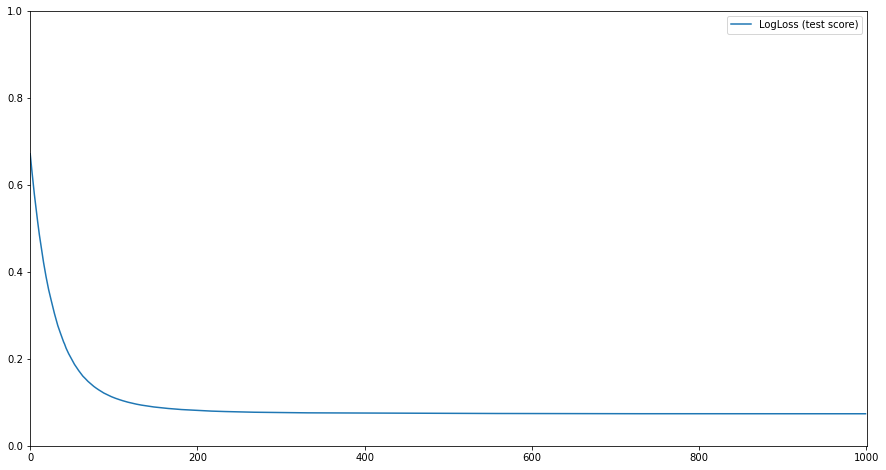

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))


ax.plot(results["cv_results"]["iterations"], results["cv_results"]["test-Logloss-mean"], label = "LogLoss (test score)")
#ax.plot(param_range, grid.cv_results_["mean_train_{}".format(strategy)], label = strategy + " (train score)")

plt.xlim(0, 1001)
plt.ylim(0, 1)
#plt.xticks(param_range)
plt.legend(loc="best")

plt.show()


In [19]:
cb_cl_new.fit(lab5_cl_x_train, lab5_cl_y_train)

0:	learn: 0.6712898	total: 19ms	remaining: 19s
1:	learn: 0.6507472	total: 27ms	remaining: 13.5s
2:	learn: 0.6327697	total: 35.5ms	remaining: 11.8s
3:	learn: 0.6139090	total: 43.6ms	remaining: 10.9s
4:	learn: 0.5958391	total: 52ms	remaining: 10.4s
5:	learn: 0.5774807	total: 60.3ms	remaining: 9.98s
6:	learn: 0.5613219	total: 68.8ms	remaining: 9.76s
7:	learn: 0.5444411	total: 77.1ms	remaining: 9.55s
8:	learn: 0.5283770	total: 85.4ms	remaining: 9.4s
9:	learn: 0.5133785	total: 93.3ms	remaining: 9.24s
10:	learn: 0.4981135	total: 102ms	remaining: 9.14s
11:	learn: 0.4841129	total: 110ms	remaining: 9.03s
12:	learn: 0.4715438	total: 118ms	remaining: 8.97s
13:	learn: 0.4586289	total: 126ms	remaining: 8.88s
14:	learn: 0.4446671	total: 134ms	remaining: 8.83s
15:	learn: 0.4319357	total: 142ms	remaining: 8.76s
16:	learn: 0.4204632	total: 151ms	remaining: 8.72s
17:	learn: 0.4090257	total: 160ms	remaining: 8.72s
18:	learn: 0.3978389	total: 169ms	remaining: 8.73s
19:	learn: 0.3877970	total: 177ms	remain

177:	learn: 0.0785906	total: 1.47s	remaining: 6.8s
178:	learn: 0.0784662	total: 1.48s	remaining: 6.79s
179:	learn: 0.0782690	total: 1.49s	remaining: 6.78s
180:	learn: 0.0781643	total: 1.5s	remaining: 6.77s
181:	learn: 0.0779772	total: 1.5s	remaining: 6.76s
182:	learn: 0.0778069	total: 1.51s	remaining: 6.75s
183:	learn: 0.0776299	total: 1.52s	remaining: 6.74s
184:	learn: 0.0774360	total: 1.53s	remaining: 6.74s
185:	learn: 0.0773256	total: 1.54s	remaining: 6.73s
186:	learn: 0.0771699	total: 1.55s	remaining: 6.72s
187:	learn: 0.0770422	total: 1.55s	remaining: 6.72s
188:	learn: 0.0768749	total: 1.56s	remaining: 6.71s
189:	learn: 0.0767353	total: 1.57s	remaining: 6.7s
190:	learn: 0.0766228	total: 1.58s	remaining: 6.7s
191:	learn: 0.0765321	total: 1.59s	remaining: 6.69s
192:	learn: 0.0763773	total: 1.6s	remaining: 6.68s
193:	learn: 0.0762453	total: 1.6s	remaining: 6.67s
194:	learn: 0.0760881	total: 1.61s	remaining: 6.67s
195:	learn: 0.0759606	total: 1.62s	remaining: 6.66s
196:	learn: 0.07581

351:	learn: 0.0657513	total: 2.92s	remaining: 5.38s
352:	learn: 0.0657241	total: 2.93s	remaining: 5.38s
353:	learn: 0.0656943	total: 2.94s	remaining: 5.37s
354:	learn: 0.0656543	total: 2.95s	remaining: 5.36s
355:	learn: 0.0656152	total: 2.96s	remaining: 5.35s
356:	learn: 0.0655779	total: 2.96s	remaining: 5.34s
357:	learn: 0.0655458	total: 2.97s	remaining: 5.33s
358:	learn: 0.0655097	total: 2.98s	remaining: 5.32s
359:	learn: 0.0654673	total: 2.99s	remaining: 5.31s
360:	learn: 0.0654286	total: 3s	remaining: 5.3s
361:	learn: 0.0653867	total: 3s	remaining: 5.3s
362:	learn: 0.0653610	total: 3.01s	remaining: 5.29s
363:	learn: 0.0653342	total: 3.02s	remaining: 5.28s
364:	learn: 0.0652830	total: 3.03s	remaining: 5.27s
365:	learn: 0.0652492	total: 3.04s	remaining: 5.26s
366:	learn: 0.0652156	total: 3.04s	remaining: 5.25s
367:	learn: 0.0651912	total: 3.05s	remaining: 5.24s
368:	learn: 0.0651652	total: 3.06s	remaining: 5.23s
369:	learn: 0.0651541	total: 3.07s	remaining: 5.22s
370:	learn: 0.065125

530:	learn: 0.0604834	total: 4.38s	remaining: 3.87s
531:	learn: 0.0604689	total: 4.39s	remaining: 3.86s
532:	learn: 0.0604549	total: 4.4s	remaining: 3.85s
533:	learn: 0.0604237	total: 4.4s	remaining: 3.84s
534:	learn: 0.0603932	total: 4.41s	remaining: 3.83s
535:	learn: 0.0603714	total: 4.42s	remaining: 3.83s
536:	learn: 0.0603383	total: 4.43s	remaining: 3.82s
537:	learn: 0.0603060	total: 4.44s	remaining: 3.81s
538:	learn: 0.0602747	total: 4.44s	remaining: 3.8s
539:	learn: 0.0602541	total: 4.45s	remaining: 3.79s
540:	learn: 0.0602336	total: 4.46s	remaining: 3.78s
541:	learn: 0.0602017	total: 4.47s	remaining: 3.78s
542:	learn: 0.0601845	total: 4.48s	remaining: 3.77s
543:	learn: 0.0601472	total: 4.48s	remaining: 3.76s
544:	learn: 0.0601170	total: 4.49s	remaining: 3.75s
545:	learn: 0.0600947	total: 4.5s	remaining: 3.74s
546:	learn: 0.0600737	total: 4.51s	remaining: 3.73s
547:	learn: 0.0600513	total: 4.52s	remaining: 3.73s
548:	learn: 0.0600326	total: 4.52s	remaining: 3.72s
549:	learn: 0.06

690:	learn: 0.0566509	total: 5.66s	remaining: 2.53s
691:	learn: 0.0566373	total: 5.66s	remaining: 2.52s
692:	learn: 0.0566203	total: 5.67s	remaining: 2.51s
693:	learn: 0.0566007	total: 5.68s	remaining: 2.5s
694:	learn: 0.0565698	total: 5.69s	remaining: 2.5s
695:	learn: 0.0565471	total: 5.69s	remaining: 2.49s
696:	learn: 0.0565370	total: 5.7s	remaining: 2.48s
697:	learn: 0.0565120	total: 5.71s	remaining: 2.47s
698:	learn: 0.0565003	total: 5.72s	remaining: 2.46s
699:	learn: 0.0564814	total: 5.72s	remaining: 2.45s
700:	learn: 0.0564595	total: 5.73s	remaining: 2.44s
701:	learn: 0.0564485	total: 5.74s	remaining: 2.44s
702:	learn: 0.0564227	total: 5.75s	remaining: 2.43s
703:	learn: 0.0563941	total: 5.76s	remaining: 2.42s
704:	learn: 0.0563642	total: 5.76s	remaining: 2.41s
705:	learn: 0.0563411	total: 5.77s	remaining: 2.4s
706:	learn: 0.0563069	total: 5.78s	remaining: 2.4s
707:	learn: 0.0562760	total: 5.79s	remaining: 2.39s
708:	learn: 0.0562628	total: 5.8s	remaining: 2.38s
709:	learn: 0.0562

868:	learn: 0.0530079	total: 7.1s	remaining: 1.07s
869:	learn: 0.0529832	total: 7.11s	remaining: 1.06s
870:	learn: 0.0529565	total: 7.12s	remaining: 1.05s
871:	learn: 0.0529452	total: 7.13s	remaining: 1.05s
872:	learn: 0.0529182	total: 7.14s	remaining: 1.04s
873:	learn: 0.0528844	total: 7.14s	remaining: 1.03s
874:	learn: 0.0528764	total: 7.15s	remaining: 1.02s
875:	learn: 0.0528559	total: 7.16s	remaining: 1.01s
876:	learn: 0.0528508	total: 7.17s	remaining: 1s
877:	learn: 0.0528364	total: 7.17s	remaining: 997ms
878:	learn: 0.0528265	total: 7.18s	remaining: 989ms
879:	learn: 0.0528056	total: 7.19s	remaining: 981ms
880:	learn: 0.0527851	total: 7.2s	remaining: 972ms
881:	learn: 0.0527646	total: 7.21s	remaining: 964ms
882:	learn: 0.0527438	total: 7.21s	remaining: 956ms
883:	learn: 0.0527132	total: 7.22s	remaining: 948ms
884:	learn: 0.0527021	total: 7.23s	remaining: 940ms
885:	learn: 0.0526887	total: 7.24s	remaining: 931ms
886:	learn: 0.0526718	total: 7.25s	remaining: 923ms
887:	learn: 0.052

In [20]:
cb_cl_prediction = cb_cl_new.predict(lab5_cl_x_test)

In [21]:
PrintClassificationMetrics(lab5_cl_y_test, cb_cl_prediction)

-Погрешность (accuracy, balanced) = 0.936325247927962;          
-Меткость (precision, класс 1) = 0.91875;          
-Полнота (recall, класс 1) = 0.8802395209580839;          
-F1 (класс 1) = 0.8990825688073394;          
-ROC AUC = 0.9363252479279619.


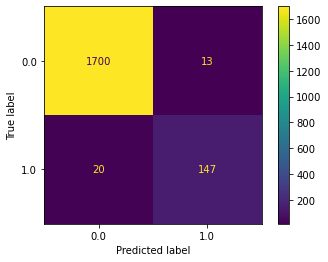

In [22]:
plot_confusion_matrix(cb_cl_new, lab5_cl_x_test, lab5_cl_y_test)

Получилось незначительно хуже. Это может означать, что подбор произошёл внутри модели автоматически и простейший решётчатый поиск проиграл.
### Дополнительное исследование
Снова попробуем сбалансировать выборку и посмотреть на результат

In [23]:
from imblearn.under_sampling import InstanceHardnessThreshold

In [24]:
iht = InstanceHardnessThreshold(random_state = RANDOM_STATE, cv = 6, n_jobs = 8)
iht_x, iht_y = iht.fit_resample(lab5_cl[columns[:-1]], lab5_cl[columns[-1]].astype("int32"))

In [25]:
iht_x_train, iht_x_test, iht_y_train, iht_y_test = train_test_split(iht_x, iht_y, random_state = RANDOM_STATE, train_size = 0.85)

In [26]:
cb_cl_iht = CatBoostClassifier(random_seed = RANDOM_STATE)
cb_cl_iht.fit(iht_x_train, iht_y_train)
cb_cl_iht_prediction = cb_cl_iht.predict(iht_x_test)

Learning rate set to 0.02356
0:	learn: 0.6362255	total: 5.63ms	remaining: 5.62s
1:	learn: 0.5904040	total: 10.6ms	remaining: 5.3s
2:	learn: 0.5478634	total: 15.7ms	remaining: 5.21s
3:	learn: 0.5059430	total: 20.9ms	remaining: 5.2s
4:	learn: 0.4687712	total: 26.2ms	remaining: 5.21s
5:	learn: 0.4308228	total: 31.3ms	remaining: 5.19s
6:	learn: 0.3994620	total: 36.5ms	remaining: 5.18s
7:	learn: 0.3745827	total: 41.6ms	remaining: 5.16s
8:	learn: 0.3481482	total: 46.7ms	remaining: 5.14s
9:	learn: 0.3256370	total: 51.7ms	remaining: 5.12s
10:	learn: 0.3008615	total: 56.8ms	remaining: 5.11s
11:	learn: 0.2808339	total: 61.9ms	remaining: 5.09s
12:	learn: 0.2612792	total: 67ms	remaining: 5.08s
13:	learn: 0.2458740	total: 72ms	remaining: 5.07s
14:	learn: 0.2310816	total: 77.1ms	remaining: 5.06s
15:	learn: 0.2155132	total: 82.2ms	remaining: 5.05s
16:	learn: 0.2042507	total: 87.2ms	remaining: 5.04s
17:	learn: 0.1921657	total: 92.3ms	remaining: 5.03s
18:	learn: 0.1798835	total: 97.4ms	remaining: 5.03s

170:	learn: 0.0355902	total: 895ms	remaining: 4.34s
171:	learn: 0.0355099	total: 901ms	remaining: 4.34s
172:	learn: 0.0354067	total: 906ms	remaining: 4.33s
173:	learn: 0.0353150	total: 911ms	remaining: 4.33s
174:	learn: 0.0352394	total: 917ms	remaining: 4.32s
175:	learn: 0.0351103	total: 922ms	remaining: 4.32s
176:	learn: 0.0350084	total: 928ms	remaining: 4.31s
177:	learn: 0.0349604	total: 933ms	remaining: 4.31s
178:	learn: 0.0348777	total: 938ms	remaining: 4.3s
179:	learn: 0.0348155	total: 943ms	remaining: 4.3s
180:	learn: 0.0347761	total: 948ms	remaining: 4.29s
181:	learn: 0.0347036	total: 953ms	remaining: 4.29s
182:	learn: 0.0346330	total: 959ms	remaining: 4.28s
183:	learn: 0.0345057	total: 964ms	remaining: 4.27s
184:	learn: 0.0344846	total: 969ms	remaining: 4.27s
185:	learn: 0.0344072	total: 974ms	remaining: 4.26s
186:	learn: 0.0343720	total: 979ms	remaining: 4.26s
187:	learn: 0.0343120	total: 985ms	remaining: 4.25s
188:	learn: 0.0342632	total: 990ms	remaining: 4.25s
189:	learn: 0.

343:	learn: 0.0259307	total: 1.79s	remaining: 3.42s
344:	learn: 0.0259117	total: 1.8s	remaining: 3.42s
345:	learn: 0.0259004	total: 1.8s	remaining: 3.41s
346:	learn: 0.0258854	total: 1.81s	remaining: 3.41s
347:	learn: 0.0258137	total: 1.81s	remaining: 3.4s
348:	learn: 0.0257858	total: 1.82s	remaining: 3.4s
349:	learn: 0.0257617	total: 1.83s	remaining: 3.39s
350:	learn: 0.0257163	total: 1.83s	remaining: 3.39s
351:	learn: 0.0256718	total: 1.84s	remaining: 3.38s
352:	learn: 0.0256432	total: 1.84s	remaining: 3.38s
353:	learn: 0.0256126	total: 1.85s	remaining: 3.37s
354:	learn: 0.0255391	total: 1.85s	remaining: 3.36s
355:	learn: 0.0255178	total: 1.86s	remaining: 3.36s
356:	learn: 0.0254955	total: 1.86s	remaining: 3.35s
357:	learn: 0.0254769	total: 1.87s	remaining: 3.35s
358:	learn: 0.0253861	total: 1.87s	remaining: 3.34s
359:	learn: 0.0253122	total: 1.88s	remaining: 3.34s
360:	learn: 0.0252920	total: 1.88s	remaining: 3.33s
361:	learn: 0.0252670	total: 1.89s	remaining: 3.33s
362:	learn: 0.02

519:	learn: 0.0214207	total: 2.69s	remaining: 2.49s
520:	learn: 0.0213771	total: 2.7s	remaining: 2.48s
521:	learn: 0.0213676	total: 2.7s	remaining: 2.48s
522:	learn: 0.0213494	total: 2.71s	remaining: 2.47s
523:	learn: 0.0213428	total: 2.71s	remaining: 2.46s
524:	learn: 0.0213338	total: 2.72s	remaining: 2.46s
525:	learn: 0.0213239	total: 2.72s	remaining: 2.46s
526:	learn: 0.0213136	total: 2.73s	remaining: 2.45s
527:	learn: 0.0212843	total: 2.73s	remaining: 2.44s
528:	learn: 0.0212233	total: 2.74s	remaining: 2.44s
529:	learn: 0.0212192	total: 2.74s	remaining: 2.43s
530:	learn: 0.0212057	total: 2.75s	remaining: 2.43s
531:	learn: 0.0211909	total: 2.75s	remaining: 2.42s
532:	learn: 0.0211736	total: 2.76s	remaining: 2.42s
533:	learn: 0.0211327	total: 2.76s	remaining: 2.41s
534:	learn: 0.0211171	total: 2.77s	remaining: 2.41s
535:	learn: 0.0211078	total: 2.77s	remaining: 2.4s
536:	learn: 0.0210478	total: 2.78s	remaining: 2.4s
537:	learn: 0.0210203	total: 2.79s	remaining: 2.39s
538:	learn: 0.02

697:	learn: 0.0171457	total: 3.6s	remaining: 1.56s
698:	learn: 0.0171445	total: 3.6s	remaining: 1.55s
699:	learn: 0.0171113	total: 3.61s	remaining: 1.55s
700:	learn: 0.0170843	total: 3.61s	remaining: 1.54s
701:	learn: 0.0170482	total: 3.62s	remaining: 1.53s
702:	learn: 0.0169965	total: 3.62s	remaining: 1.53s
703:	learn: 0.0169899	total: 3.63s	remaining: 1.52s
704:	learn: 0.0169824	total: 3.63s	remaining: 1.52s
705:	learn: 0.0169765	total: 3.64s	remaining: 1.51s
706:	learn: 0.0169509	total: 3.64s	remaining: 1.51s
707:	learn: 0.0169263	total: 3.65s	remaining: 1.5s
708:	learn: 0.0168949	total: 3.65s	remaining: 1.5s
709:	learn: 0.0168663	total: 3.66s	remaining: 1.49s
710:	learn: 0.0168533	total: 3.66s	remaining: 1.49s
711:	learn: 0.0168476	total: 3.67s	remaining: 1.48s
712:	learn: 0.0168243	total: 3.67s	remaining: 1.48s
713:	learn: 0.0167848	total: 3.68s	remaining: 1.47s
714:	learn: 0.0167567	total: 3.69s	remaining: 1.47s
715:	learn: 0.0167339	total: 3.69s	remaining: 1.46s
716:	learn: 0.01

874:	learn: 0.0136836	total: 4.5s	remaining: 643ms
875:	learn: 0.0136594	total: 4.5s	remaining: 638ms
876:	learn: 0.0136363	total: 4.51s	remaining: 632ms
877:	learn: 0.0135936	total: 4.51s	remaining: 627ms
878:	learn: 0.0135849	total: 4.52s	remaining: 622ms
879:	learn: 0.0135726	total: 4.52s	remaining: 617ms
880:	learn: 0.0135602	total: 4.53s	remaining: 612ms
881:	learn: 0.0135483	total: 4.53s	remaining: 607ms
882:	learn: 0.0135290	total: 4.54s	remaining: 602ms
883:	learn: 0.0135054	total: 4.54s	remaining: 596ms
884:	learn: 0.0134964	total: 4.55s	remaining: 591ms
885:	learn: 0.0134735	total: 4.55s	remaining: 586ms
886:	learn: 0.0134515	total: 4.56s	remaining: 581ms
887:	learn: 0.0134454	total: 4.57s	remaining: 576ms
888:	learn: 0.0134323	total: 4.57s	remaining: 571ms
889:	learn: 0.0134163	total: 4.58s	remaining: 566ms
890:	learn: 0.0134135	total: 4.58s	remaining: 560ms
891:	learn: 0.0133764	total: 4.58s	remaining: 555ms
892:	learn: 0.0133475	total: 4.59s	remaining: 550ms
893:	learn: 0.

(выбрал другое значение LearningRate)

In [27]:
PrintClassificationMetrics(iht_y_test, cb_cl_iht_prediction)

-Погрешность (accuracy, balanced) = 0.9484848484848485;          
-Меткость (precision, класс 1) = 1.0;          
-Полнота (recall, класс 1) = 0.896969696969697;          
-F1 (класс 1) = 0.9456869009584664;          
-ROC AUC = 0.9484848484848485.


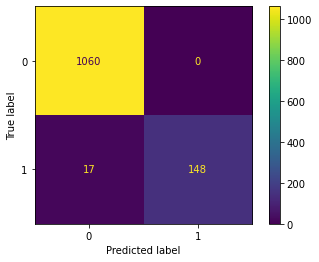

In [28]:
plot_confusion_matrix(cb_cl_iht, iht_x_test, iht_y_test)

Результат говорит сам за себя!
## Часть 2. Регрессия

In [29]:
def MoveColumnToEnd(data, column_name):
    columns = data.columns.tolist()
    column = columns.pop(columns.index(column_name))
    columns.append(column)
    return columns


lab5_regr = pd.read_csv("ML_Datasets/Lab2/lab2_scaled.csv")
columns = MoveColumnToEnd(lab5_regr, "Price")[1:]
lab5_regr = lab5_regr[columns]



In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score


def PrintRegressionMetrics(y_test, y_predicted):
    print("-Средняя абсолютная ошибка = {0};\
          \n-Медианная абсолютная ошибка = {1};\
          \n-Среднеквадратичная ошибка = {2};\
          \n-Коэффициент детерминации = {3}.".format(mean_absolute_error(y_test, y_predicted),
                                                        median_absolute_error(y_test, y_predicted),
                                                        mean_squared_error(y_test, y_predicted, squared = False),
                                                        r2_score(y_test, y_predicted)))
    
def FitPredictRegr(model, x_train, x_test, y_train, y_test):
    solver = model
    solver.fit(x_train, y_train)
    prediction = solver.predict(x_test)
    PrintRegressionMetrics(y_test, prediction)

In [31]:
lab5_regr_x_train, lab5_regr_x_test, lab5_regr_y_train, lab5_regr_y_test = train_test_split(lab5_regr[columns[:-1]], 
                                                                                            lab5_regr[columns[-1]],
                                                                                            train_size = 0.85,
                                                                                            random_state = RANDOM_STATE)

### Бэггинг

In [32]:
FitPredictRegr(BaggingRegressor(random_state = RANDOM_STATE), lab5_regr_x_train, lab5_regr_x_test, lab5_regr_y_train, lab5_regr_y_test)

-Средняя абсолютная ошибка = 0.13489055988703724;          
-Медианная абсолютная ошибка = 0.05112312126793245;          
-Среднеквадратичная ошибка = 0.3007806042422112;          
-Коэффициент детерминации = 0.8951171622792088.


Здесь уже видим существенный прирост в сравнении с наилучшей моделью из предыдущей работы - SVR-RBF

In [33]:
from sklearn.model_selection import ShuffleSplit


cv_scoring_strategies = {"RMSE (negative)" : "neg_root_mean_squared_error",
                         "MedianAE" : "neg_median_absolute_error",
                         "R2-score" : "r2"}

estimators_range = [i for i in range(1, 25)]

bagging_regr_grid = GridSearchCV(estimator = BaggingRegressor(random_state = RANDOM_STATE),
                              param_grid = [{"n_estimators" : estimators_range}],
                              cv = ShuffleSplit(random_state = RANDOM_STATE),
                              n_jobs = 8,
                              scoring = cv_scoring_strategies,
                              refit = False,
                              return_train_score = True)

bagging_regr_grid.fit(lab5_regr[columns[:-1]], lab5_regr[columns[-1]])

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=6, test_size=None, train_size=None),
             estimator=BaggingRegressor(random_state=6), n_jobs=8,
             param_grid=[{'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13, 14, 15, 16, 17, 18, 19, 20,
                                           21, 22, 23, 24]}],
             refit=False, return_train_score=True,
             scoring={'MedianAE': 'neg_median_absolute_error', 'R2-score': 'r2',
                      'RMSE (negative)': 'neg_root_mean_squared_error'})

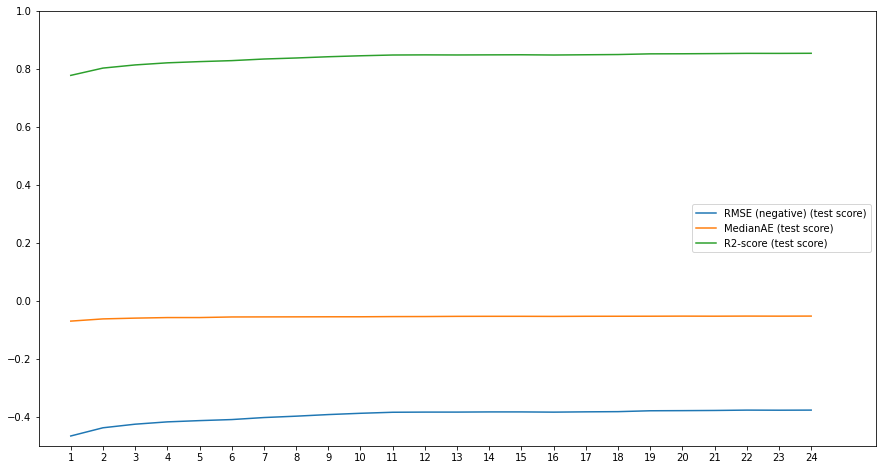

In [34]:
PlotGridSearchResults(cv_scoring_strategies, bagging_regr_grid, estimators_range, 0, 26, -0.5, 1)

In [35]:
FitPredictRegr(BaggingRegressor(n_estimators = 19, random_state = RANDOM_STATE), lab5_regr_x_train, lab5_regr_x_test, lab5_regr_y_train, lab5_regr_y_test)

-Средняя абсолютная ошибка = 0.12781867263767066;          
-Медианная абсолютная ошибка = 0.05235557045565786;          
-Среднеквадратичная ошибка = 0.26801513545482347;          
-Коэффициент детерминации = 0.9167233176619671.


### Случайный лес

In [36]:
FitPredictRegr(RandomForestRegressor(random_state = RANDOM_STATE), lab5_regr_x_train, lab5_regr_x_test, lab5_regr_y_train, lab5_regr_y_test)

-Средняя абсолютная ошибка = 0.12466018147348676;          
-Медианная абсолютная ошибка = 0.05113205887654604;          
-Среднеквадратичная ошибка = 0.26290791365495664;          
-Коэффициент детерминации = 0.9198668727344836.


In [37]:
estimators_range = [i for i in range(1, 102, 4)]

rf_regr_grid = GridSearchCV(estimator = RandomForestRegressor(random_state = RANDOM_STATE),
                              param_grid = [{"n_estimators" : estimators_range}],
                              cv = ShuffleSplit(random_state = RANDOM_STATE),
                              n_jobs = 8,
                              scoring = cv_scoring_strategies,
                              refit = False,
                              return_train_score = True)

rf_regr_grid.fit(lab5_regr[columns[:-1]], lab5_regr[columns[-1]])

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=6, test_size=None, train_size=None),
             estimator=RandomForestRegressor(random_state=6), n_jobs=8,
             param_grid=[{'n_estimators': [1, 5, 9, 13, 17, 21, 25, 29, 33, 37,
                                           41, 45, 49, 53, 57, 61, 65, 69, 73,
                                           77, 81, 85, 89, 93, 97, 101]}],
             refit=False, return_train_score=True,
             scoring={'MedianAE': 'neg_median_absolute_error', 'R2-score': 'r2',
                      'RMSE (negative)': 'neg_root_mean_squared_error'})

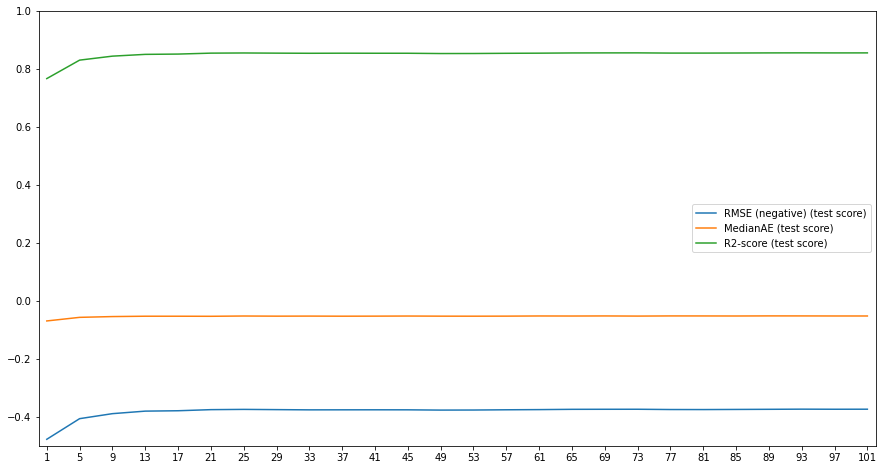

In [38]:
PlotGridSearchResults(cv_scoring_strategies, rf_regr_grid, estimators_range, 0, 102, -0.5, 1)

In [39]:
FitPredictRegr(RandomForestRegressor(n_estimators = 30, random_state = RANDOM_STATE), lab5_regr_x_train, lab5_regr_x_test, lab5_regr_y_train, lab5_regr_y_test)

-Средняя абсолютная ошибка = 0.12650711293649639;          
-Медианная абсолютная ошибка = 0.052910642990587564;          
-Среднеквадратичная ошибка = 0.2669840880173342;          
-Коэффициент детерминации = 0.9173628118077617.


### CatBoost

In [40]:
cb_regr = CatBoostRegressor(random_seed = RANDOM_STATE)
cb_regr.fit(lab5_regr_x_train, lab5_regr_y_train)
cb_regr_prediction = cb_regr.predict(lab5_regr_x_test)

Learning rate set to 0.052187
0:	learn: 0.9752961	total: 2.63ms	remaining: 2.63s
1:	learn: 0.9392755	total: 4.91ms	remaining: 2.45s
2:	learn: 0.9046029	total: 7.19ms	remaining: 2.39s
3:	learn: 0.8719543	total: 9.49ms	remaining: 2.36s
4:	learn: 0.8406479	total: 11.8ms	remaining: 2.34s
5:	learn: 0.8127355	total: 14.1ms	remaining: 2.34s
6:	learn: 0.7857565	total: 16.4ms	remaining: 2.33s
7:	learn: 0.7610209	total: 18.7ms	remaining: 2.32s
8:	learn: 0.7381586	total: 20.9ms	remaining: 2.3s
9:	learn: 0.7157287	total: 23.2ms	remaining: 2.3s
10:	learn: 0.6956452	total: 25.5ms	remaining: 2.29s
11:	learn: 0.6748119	total: 27.8ms	remaining: 2.29s
12:	learn: 0.6561441	total: 30.1ms	remaining: 2.29s
13:	learn: 0.6391546	total: 32.4ms	remaining: 2.28s
14:	learn: 0.6230648	total: 34.7ms	remaining: 2.28s
15:	learn: 0.6073891	total: 37ms	remaining: 2.27s
16:	learn: 0.5926161	total: 39.2ms	remaining: 2.27s
17:	learn: 0.5796076	total: 41.6ms	remaining: 2.27s
18:	learn: 0.5665119	total: 43.9ms	remaining: 2.

217:	learn: 0.2546759	total: 494ms	remaining: 1.77s
218:	learn: 0.2544599	total: 496ms	remaining: 1.77s
219:	learn: 0.2541553	total: 498ms	remaining: 1.77s
220:	learn: 0.2539595	total: 500ms	remaining: 1.76s
221:	learn: 0.2536747	total: 503ms	remaining: 1.76s
222:	learn: 0.2531786	total: 505ms	remaining: 1.76s
223:	learn: 0.2526139	total: 507ms	remaining: 1.76s
224:	learn: 0.2524293	total: 509ms	remaining: 1.75s
225:	learn: 0.2518501	total: 512ms	remaining: 1.75s
226:	learn: 0.2513627	total: 514ms	remaining: 1.75s
227:	learn: 0.2511575	total: 516ms	remaining: 1.75s
228:	learn: 0.2510366	total: 519ms	remaining: 1.75s
229:	learn: 0.2506843	total: 521ms	remaining: 1.74s
230:	learn: 0.2499931	total: 523ms	remaining: 1.74s
231:	learn: 0.2497021	total: 525ms	remaining: 1.74s
232:	learn: 0.2495942	total: 528ms	remaining: 1.74s
233:	learn: 0.2492251	total: 530ms	remaining: 1.73s
234:	learn: 0.2491392	total: 532ms	remaining: 1.73s
235:	learn: 0.2486914	total: 534ms	remaining: 1.73s
236:	learn: 

377:	learn: 0.2091496	total: 852ms	remaining: 1.4s
378:	learn: 0.2090276	total: 854ms	remaining: 1.4s
379:	learn: 0.2090161	total: 856ms	remaining: 1.4s
380:	learn: 0.2086828	total: 858ms	remaining: 1.39s
381:	learn: 0.2083701	total: 860ms	remaining: 1.39s
382:	learn: 0.2081445	total: 863ms	remaining: 1.39s
383:	learn: 0.2081335	total: 864ms	remaining: 1.39s
384:	learn: 0.2079361	total: 867ms	remaining: 1.38s
385:	learn: 0.2077700	total: 869ms	remaining: 1.38s
386:	learn: 0.2075310	total: 871ms	remaining: 1.38s
387:	learn: 0.2072798	total: 873ms	remaining: 1.38s
388:	learn: 0.2072342	total: 876ms	remaining: 1.38s
389:	learn: 0.2071901	total: 878ms	remaining: 1.37s
390:	learn: 0.2068843	total: 880ms	remaining: 1.37s
391:	learn: 0.2068698	total: 882ms	remaining: 1.37s
392:	learn: 0.2063818	total: 885ms	remaining: 1.37s
393:	learn: 0.2060290	total: 887ms	remaining: 1.36s
394:	learn: 0.2059534	total: 889ms	remaining: 1.36s
395:	learn: 0.2055553	total: 891ms	remaining: 1.36s
396:	learn: 0.2

599:	learn: 0.1690895	total: 1.35s	remaining: 903ms
600:	learn: 0.1688316	total: 1.36s	remaining: 901ms
601:	learn: 0.1686367	total: 1.36s	remaining: 898ms
602:	learn: 0.1685340	total: 1.36s	remaining: 896ms
603:	learn: 0.1684151	total: 1.36s	remaining: 894ms
604:	learn: 0.1682179	total: 1.36s	remaining: 892ms
605:	learn: 0.1679640	total: 1.37s	remaining: 889ms
606:	learn: 0.1678819	total: 1.37s	remaining: 887ms
607:	learn: 0.1676935	total: 1.37s	remaining: 885ms
608:	learn: 0.1675789	total: 1.37s	remaining: 883ms
609:	learn: 0.1675029	total: 1.38s	remaining: 880ms
610:	learn: 0.1672389	total: 1.38s	remaining: 878ms
611:	learn: 0.1671550	total: 1.38s	remaining: 876ms
612:	learn: 0.1669526	total: 1.38s	remaining: 874ms
613:	learn: 0.1668250	total: 1.39s	remaining: 871ms
614:	learn: 0.1667237	total: 1.39s	remaining: 869ms
615:	learn: 0.1666538	total: 1.39s	remaining: 867ms
616:	learn: 0.1665266	total: 1.39s	remaining: 865ms
617:	learn: 0.1663074	total: 1.4s	remaining: 862ms
618:	learn: 0

824:	learn: 0.1423930	total: 1.87s	remaining: 397ms
825:	learn: 0.1422649	total: 1.87s	remaining: 394ms
826:	learn: 0.1422049	total: 1.87s	remaining: 392ms
827:	learn: 0.1420862	total: 1.88s	remaining: 390ms
828:	learn: 0.1419764	total: 1.88s	remaining: 388ms
829:	learn: 0.1418876	total: 1.88s	remaining: 385ms
830:	learn: 0.1418337	total: 1.88s	remaining: 383ms
831:	learn: 0.1417274	total: 1.89s	remaining: 381ms
832:	learn: 0.1416602	total: 1.89s	remaining: 379ms
833:	learn: 0.1415853	total: 1.89s	remaining: 376ms
834:	learn: 0.1414802	total: 1.89s	remaining: 374ms
835:	learn: 0.1413973	total: 1.9s	remaining: 372ms
836:	learn: 0.1413184	total: 1.9s	remaining: 370ms
837:	learn: 0.1412625	total: 1.9s	remaining: 367ms
838:	learn: 0.1411656	total: 1.9s	remaining: 365ms
839:	learn: 0.1411420	total: 1.9s	remaining: 363ms
840:	learn: 0.1410231	total: 1.91s	remaining: 361ms
841:	learn: 0.1409376	total: 1.91s	remaining: 358ms
842:	learn: 0.1408243	total: 1.91s	remaining: 356ms
843:	learn: 0.140

In [41]:
PrintRegressionMetrics(lab5_regr_y_test, cb_regr_prediction)

-Средняя абсолютная ошибка = 0.10996347236055334;          
-Медианная абсолютная ошибка = 0.05227442553169892;          
-Среднеквадратичная ошибка = 0.2186342447884883;          
-Коэффициент детерминации = 0.9445832378384268.
